<a href="https://colab.research.google.com/github/ranrania3/BladderCancer-Scripts/blob/main/Final_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# 📌 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
import joblib
from sklearn.svm import LinearSVC
from google.colab import files
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
import re
from sklearn.model_selection import cross_val_score

In [9]:
df = pd.read_excel('/content/BC_dataset_final.xlsx')
df.head()

,Patient ID,Diagnosis Age,Prostate Cancer UICC TNM Stage,UICC Metastasis Stage Code,UICC TNM Tumor Stage Code,Angiolymphatic Invasion,Disease Free (Months),Disease Free Status,Family History Cancer Relationship,Neoplasm Histologic Grade,...,New Neoplasm Event Post Initial Therapy Indicator,History of Noninvasive Bladder Cancer,Occupation Current,Overall Survival (Months),Overall Survival Status,Adjuvant Postoperative Pharmaceutical Therapy Administered Indicator,Did patient start adjuvant postoperative radiotherapy?,Sex,Patient Smoking History Category,Person Neoplasm Status
0,1,63,NO,M0,T3,NO,21.39,1,NaN,High Grade,...,YES,NO,unemployed,24.11,1,NO,NO,Male,2,WITH TUMOR
1,2,66,NO,MX,T3a,YES,11.27,1,NaN,High Grade,...,YES,NO,Retired,11.96,1,NO,NO,Male,4,WITH TUMOR
2,3,69,NO,M0,T3a,YES,94.81,0,NaN,High Grade,...,NO,NO,Retired,94.81,0,NO,NO,Male,1,TUMOR FREE
3,4,59,NO,M0,T3a,YES,101.38,1,NaN,High Grade,...,YES,NO,Homemaker,104.57,1,NO,NO,Female,2,WITH TUMOR
4,5,83,pT2a,M0,T2b,NO,108.87,0,NaN,High Grade,...,NO,NO,Retired,108.87,0,NO,NO,Male,2,TUMOR FREE


In [10]:
print("📊 Dataset Info:")
print(f"Shape: {df.shape}")
print("\n🔍 Column Summary:")
print(df.info())

print("\n📈 Class Distribution:")
print(df['Disease Free Status'].value_counts(normalize=True))

📊 Dataset Info:
Shape: (405, 25)

🔍 Column Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 25 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Patient ID                                                            405 non-null    int64  
 1   Diagnosis Age                                                         405 non-null    int64  
 2   Prostate Cancer UICC TNM Stage                                        405 non-null    object 
 3   UICC Metastasis Stage Code                                            405 non-null    object 
 4   UICC TNM Tumor Stage Code                                             405 non-null    object 
 5   Angiolymphatic Invasion                                               405 non-null    object 
 6   Disease Free (Months)                         

In [11]:
# 📌 3. Cible et exclusion de colonnes inutiles
target = 'Disease Free Status'
excluded_columns = ['Patient ID', 'Overall Survival (Months)', 'Overall Survival Status']
X = df.drop(columns=[target] + excluded_columns)
y = df[target]

# 📌 4. Encodage des variables catégorielles
X = pd.get_dummies(X)

In [5]:
# 📌 5. Séparation train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"📊 Train set: {X_train.shape}")
print(f"📊 Test set: {X_test.shape}")
print(f"📊 Train class distribution: {y_train.value_counts(normalize=True).to_dict()}")
print(f"📊 Test class distribution: {y_test.value_counts(normalize=True).to_dict()}")

📊 Train set: (324, 202)
📊 Test set: (81, 202)
📊 Train class distribution: {1: 0.5123456790123457, 0: 0.4876543209876543}
📊 Test class distribution: {1: 0.5061728395061729, 0: 0.49382716049382713}


Optimal number of features: 12 (CV score: 0.7747)


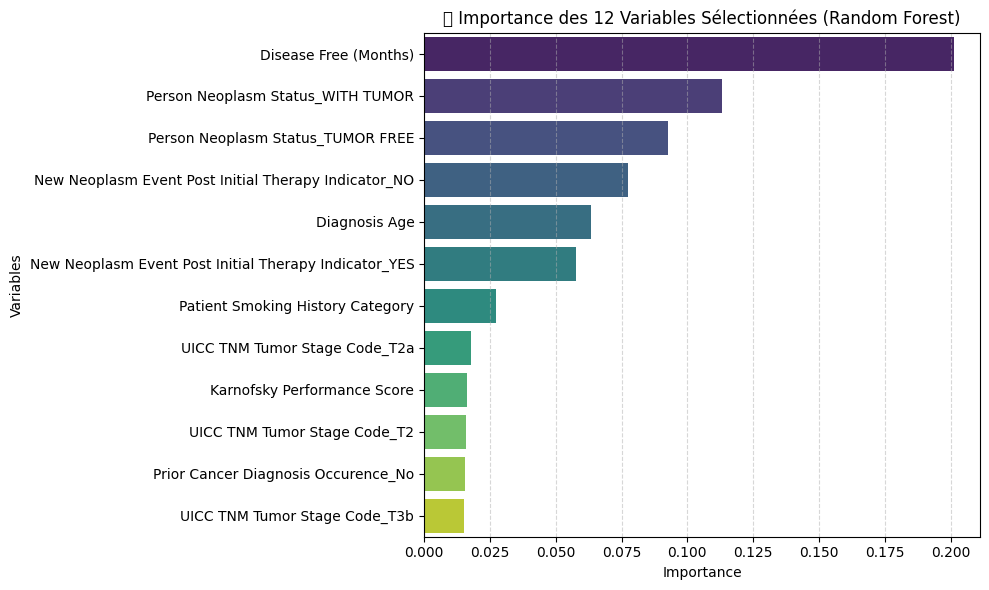

In [12]:
# 📌 6. Sélection automatique du nombre optimal de variables (Random Forest simple)
initial_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
initial_model.fit(X_train, y_train)

importances = initial_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Test automatique pour choisir le meilleur nombre de features
best_score = 0
best_n_features = 12

for n_features in [12, 15, 20]:
    selected_features_temp = X_train.columns[indices][:n_features]
    X_train_temp = X_train[selected_features_temp]

    cv_score = cross_val_score(initial_model, X_train_temp, y_train, cv=3, scoring='accuracy').mean()

    if cv_score > best_score:
        best_score = cv_score
        best_n_features = n_features

print(f"Optimal number of features: {best_n_features} (CV score: {best_score:.4f})")

# Application du nombre optimal
selected_features = X_train.columns[indices][:best_n_features]
top_importances = importances[indices][:best_n_features]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 📊 Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=selected_features, palette="viridis")
plt.title(f"🎯 Importance des {best_n_features} Variables Sélectionnées (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10],               # allow deeper trees again
    'min_samples_split': [2, 4],           # allow smaller splits again
    'min_samples_leaf': [1, 2],            # smaller leaves
    'max_features': ['sqrt', 0.8],         # try more features
    'bootstrap': [True],
    'class_weight': ['balanced']
}

In [14]:
# 📌 8. GridSearchCV pour trouver les meilleurs paramètres
base_model = RandomForestClassifier(random_state=42)
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score)
}

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    refit='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_selected, y_train)
best_rf_model = grid_search.best_estimator_

print("✅ Meilleurs paramètres trouvés :", grid_search.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Meilleurs paramètres trouvés : {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}



🌲 Step 5: ROC Curve & Threshold Analysis for Final Random Forest Model


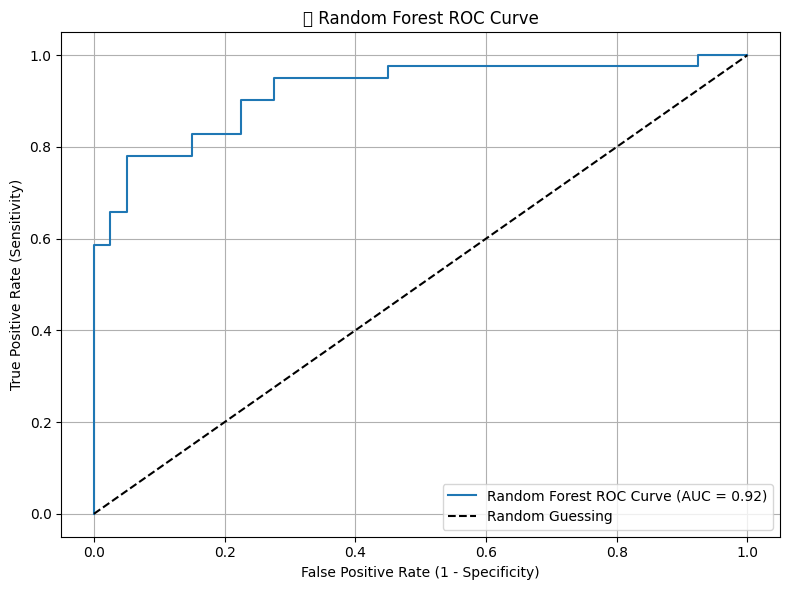


✅ Best threshold found: 0.2952
🔹 Sensitivity (Test): 0.9512
🔹 Specificity (Test): 0.7250


In [15]:
print("\n🌲 Step 5: ROC Curve & Threshold Analysis for Final Random Forest Model")

# Use the best Random Forest model from GridSearch
final_rf_model = clone(best_rf_model)
final_rf_model.fit(X_train_selected, y_train)
# Predicted probabilities on test and train sets
y_proba_train_rf = final_rf_model.predict_proba(X_train_selected)[:, 1]
y_proba_test_rf = final_rf_model.predict_proba(X_test_selected)[:, 1]


# ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_test_rf)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC Curve (AUC = {roc_auc_score(y_test, y_proba_test_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('🌲 Random Forest ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 Threshold Optimization: Maximize Sensitivity with Specificity ≥ 60%
best_thresh_rf = 0.5
best_sens_rf = 0
best_spec_rf = 0

for thresh in thresholds_rf:
    y_pred_thresh_rf = (y_proba_test_rf >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh_rf).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    if specificity >= 0.60 and sensitivity > best_sens_rf:
        best_thresh_rf = thresh
        best_sens_rf = sensitivity
        best_spec_rf = specificity

# Output best threshold info
if best_sens_rf > 0:
    print(f"\n✅ Best threshold found: {best_thresh_rf:.4f}")
    print(f"🔹 Sensitivity (Test): {best_sens_rf:.4f}")
    print(f"🔹 Specificity (Test): {best_spec_rf:.4f}")
else:
    print("\n❌ No threshold found that satisfies: specificity ≥ 60%")


Calculating detailed metrics for all parameter combinations...


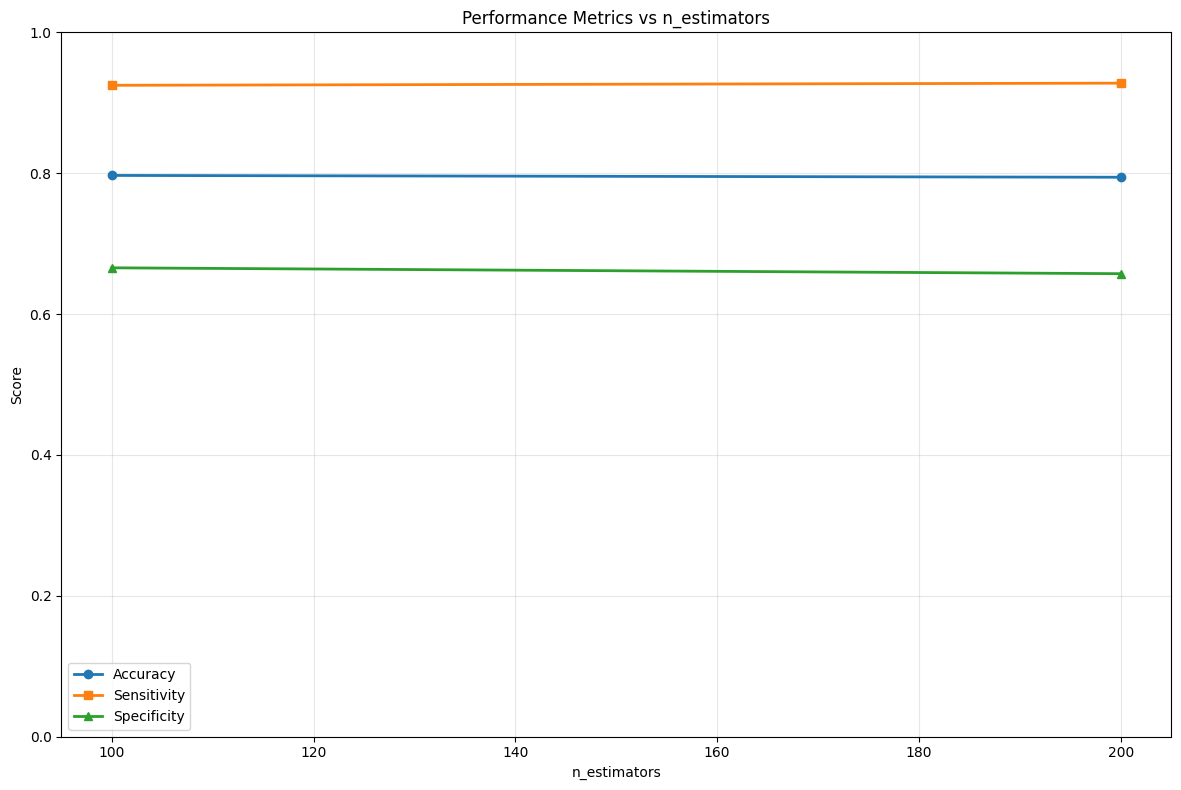

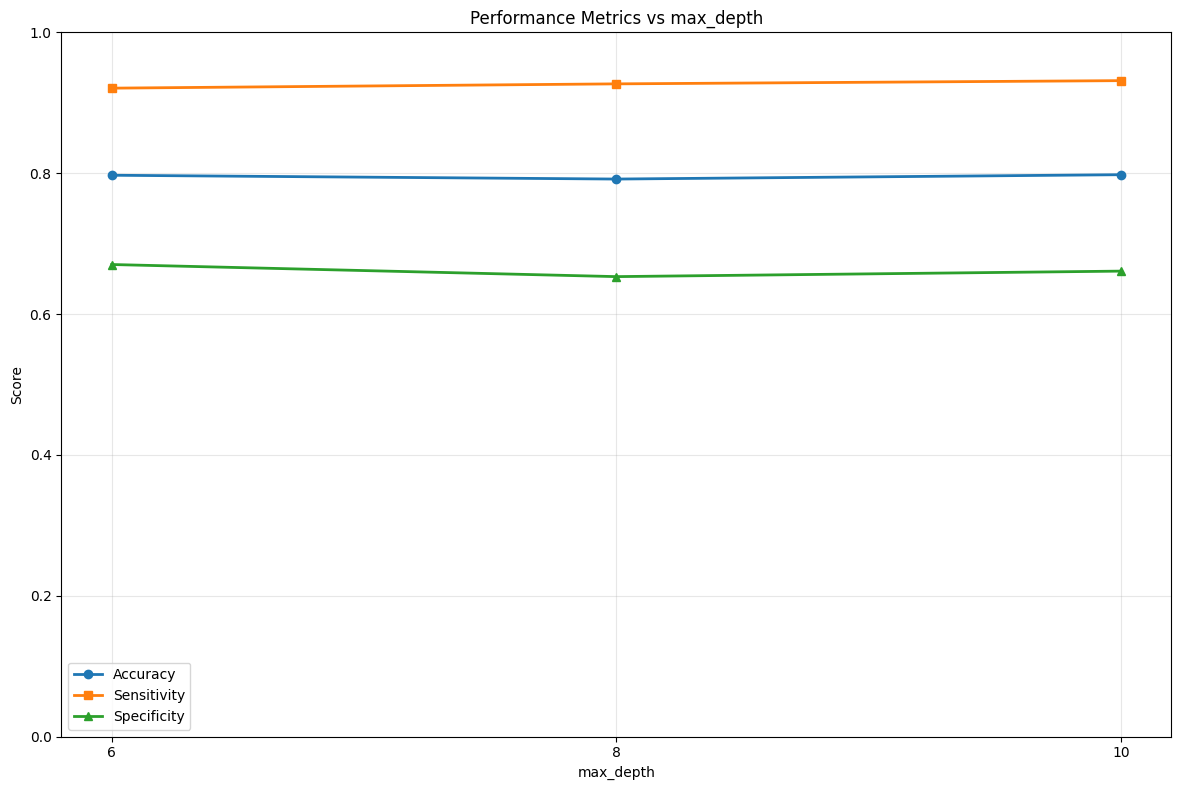

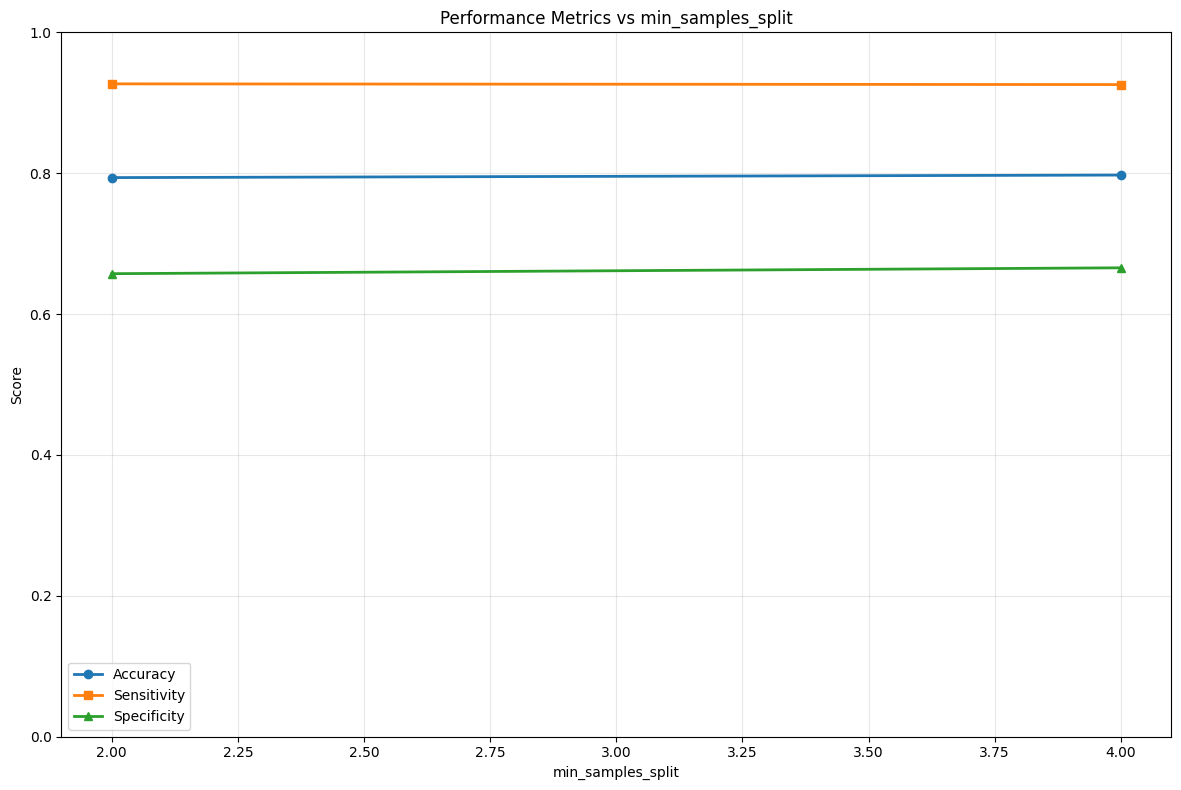

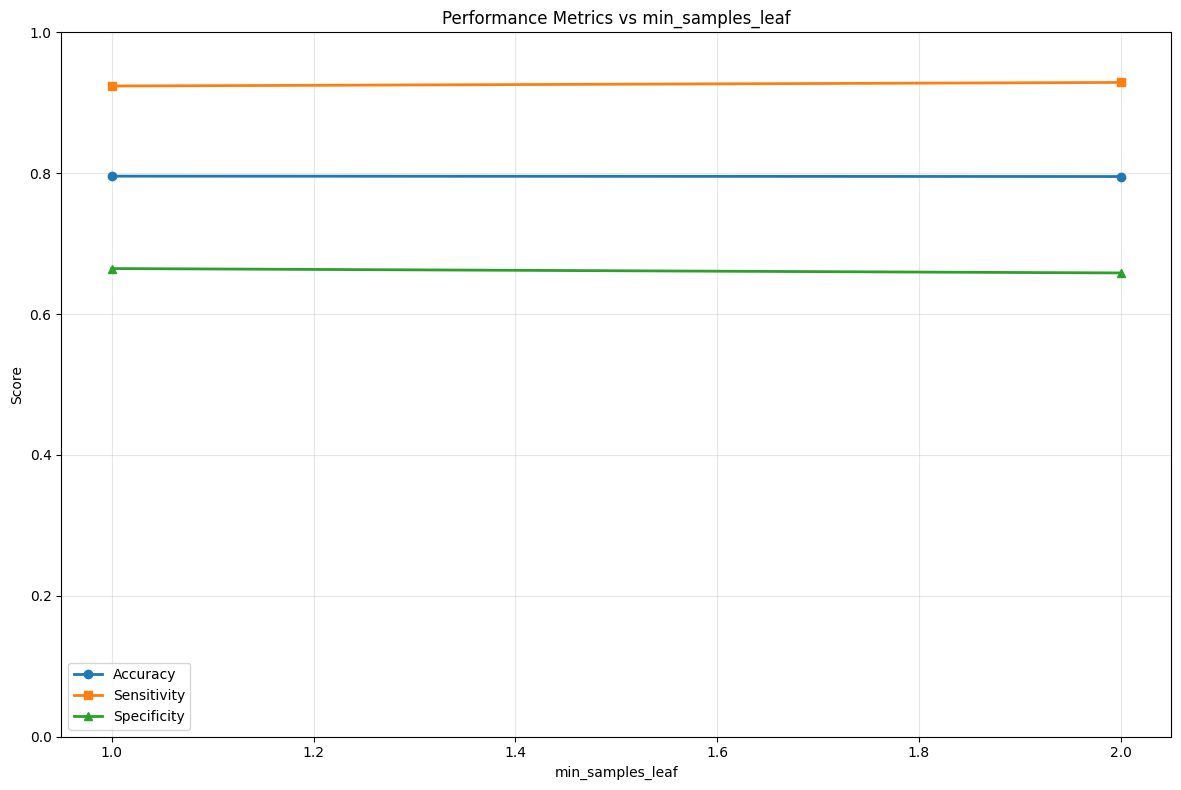

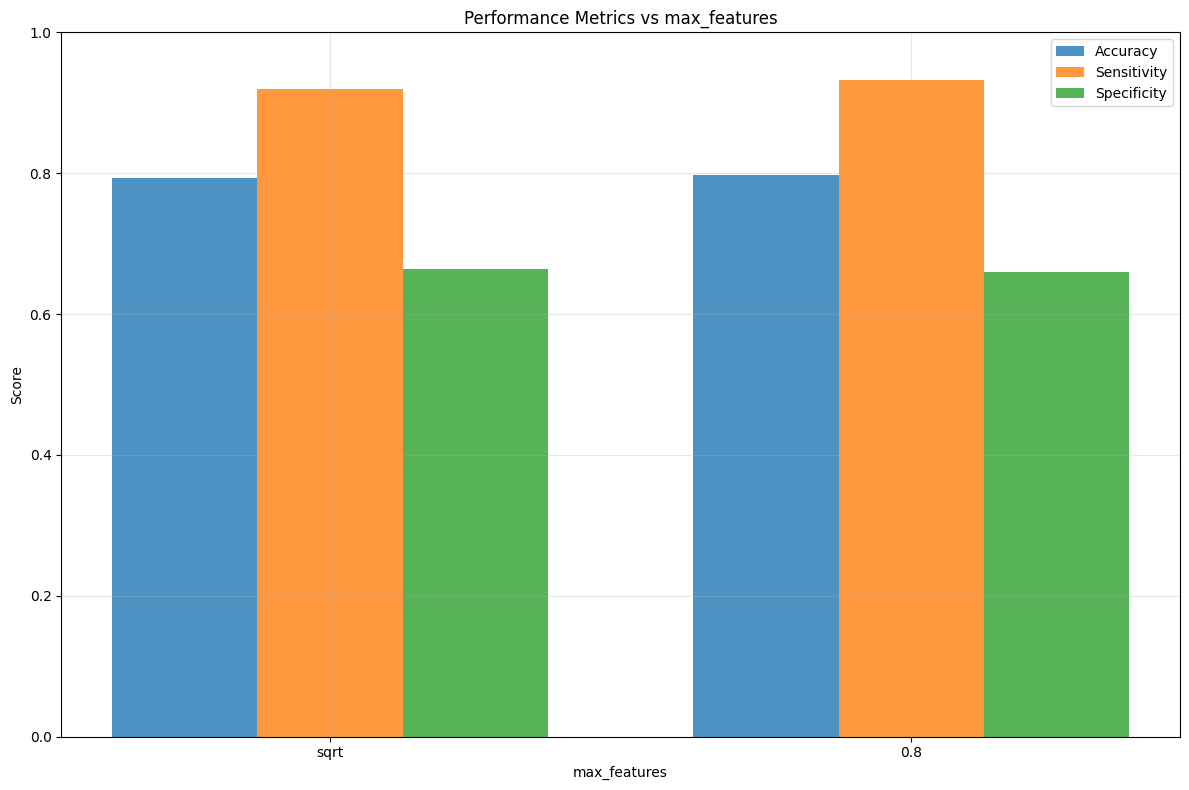

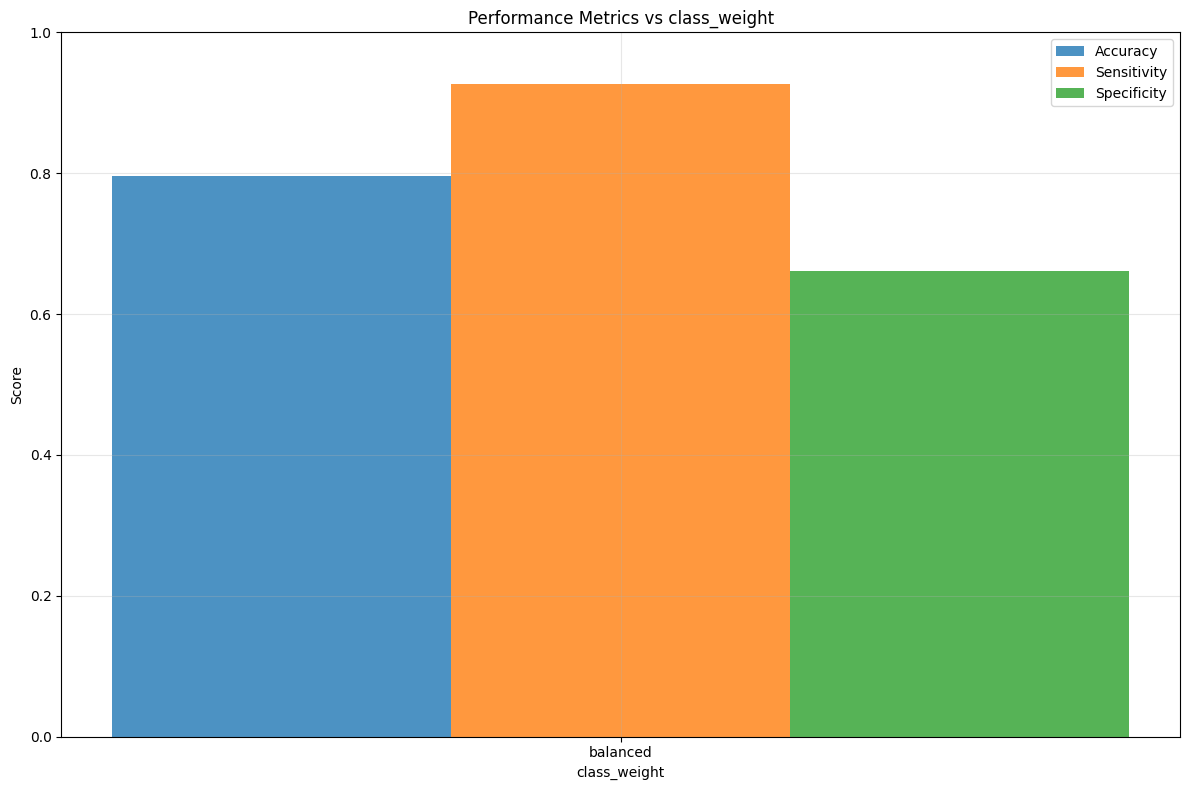


📋 Best parameter combinations for each metric:

🎯 Best Accuracy:
Accuracy: 0.840
n_estimators: 100
max_depth: 6
min_samples_split: 4
min_samples_leaf: 1
max_features: sqrt
class_weight: balanced

🎯 Best Sensitivity:
Sensitivity: 0.951
n_estimators: 100
max_depth: 6
min_samples_split: 4
min_samples_leaf: 1
max_features: sqrt
class_weight: balanced

🎯 Best Specificity:
Specificity: 0.725
n_estimators: 100
max_depth: 6
min_samples_split: 4
min_samples_leaf: 1
max_features: sqrt
class_weight: balanced

📈 Parameter impact summary (correlation with metrics):
           Parameter  Accuracy_Corr  Sensitivity_Corr  Specificity_Corr
0       n_estimators         -0.090             0.095            -0.163
1          max_depth          0.022             0.270            -0.150
2  min_samples_split          0.126            -0.032             0.163
3   min_samples_leaf         -0.018             0.158            -0.123


In [16]:
# First, we need to get predictions for all parameter combinations
detailed_results = []

print("Calculating detailed metrics for all parameter combinations...")
for i, params in enumerate(grid_search.cv_results_['params']):
    # Create model with these parameters
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_selected, y_train)

    # Get predictions with your custom threshold
    y_proba = model.predict_proba(X_test_selected)[:, 1]
    y_pred = (y_proba >= best_thresh_rf).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)

    # Calculate specificity
    cm = confusion_matrix(y_test, y_pred)
    tn, fp = cm[0, 0], cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Store results
    result = params.copy()
    result.update({
        'accuracy': acc,
        'sensitivity': sensitivity,
        'specificity': specificity
    })
    detailed_results.append(result)

# Convert to DataFrame
detailed_df = pd.DataFrame(detailed_results)

# 📈 Plot for each hyperparameter
hyperparameters = ['n_estimators', 'max_depth', 'min_samples_split',
                   'min_samples_leaf', 'max_features', 'class_weight']

for param in hyperparameters:
    plt.figure(figsize=(12, 8))

    # Get unique values for this parameter
    unique_values = detailed_df[param].unique()

    # Check if parameter is numeric or categorical
    if param in ['max_features', 'class_weight']:
        # Categorical parameter - use bar plot
        metrics_by_param = detailed_df.groupby(param)[['accuracy', 'sensitivity', 'specificity']].mean()

        x_pos = np.arange(len(unique_values))
        width = 0.25

        plt.bar(x_pos - width, metrics_by_param['accuracy'], width, label='Accuracy', alpha=0.8)
        plt.bar(x_pos, metrics_by_param['sensitivity'], width, label='Sensitivity', alpha=0.8)
        plt.bar(x_pos + width, metrics_by_param['specificity'], width, label='Specificity', alpha=0.8)

        plt.xlabel(param)
        plt.ylabel('Score')
        plt.title(f'Performance Metrics vs {param}')
        plt.xticks(x_pos, unique_values)
        plt.legend()
        plt.grid(True, alpha=0.3)

    else:
        # Numeric parameter - use line plot
        # Sort values for proper line connection
        if param == 'max_depth':
            # Handle None values in max_depth
            plot_data = detailed_df.copy()
            plot_data[param] = plot_data[param].fillna(999)  # Replace None with large number for sorting
            plot_data = plot_data.sort_values(param)

            # Group by parameter value and calculate mean metrics
            metrics_by_param = plot_data.groupby(param)[['accuracy', 'sensitivity', 'specificity']].mean()

            # Convert back None for display
            x_values = [None if x == 999 else x for x in metrics_by_param.index]
            x_labels = ['None' if x is None else str(int(x)) for x in x_values]
            x_positions = range(len(x_values))

            plt.plot(x_positions, metrics_by_param['accuracy'], marker='o', label='Accuracy', linewidth=2)
            plt.plot(x_positions, metrics_by_param['sensitivity'], marker='s', label='Sensitivity', linewidth=2)
            plt.plot(x_positions, metrics_by_param['specificity'], marker='^', label='Specificity', linewidth=2)

            plt.xticks(x_positions, x_labels)

        else:
            # Regular numeric parameters
            metrics_by_param = detailed_df.groupby(param)[['accuracy', 'sensitivity', 'specificity']].mean().sort_index()

            plt.plot(metrics_by_param.index, metrics_by_param['accuracy'], marker='o', label='Accuracy', linewidth=2)
            plt.plot(metrics_by_param.index, metrics_by_param['sensitivity'], marker='s', label='Sensitivity', linewidth=2)
            plt.plot(metrics_by_param.index, metrics_by_param['specificity'], marker='^', label='Specificity', linewidth=2)

        plt.xlabel(param)
        plt.ylabel('Score')
        plt.title(f'Performance Metrics vs {param}')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.ylim(0, 1)  # Set y-axis limits for better comparison
    plt.show()

# 📊 Summary table of best combinations for each metric
print("\n📋 Best parameter combinations for each metric:")
print("\n🎯 Best Accuracy:")
best_acc_idx = detailed_df['accuracy'].idxmax()
print(f"Accuracy: {detailed_df.loc[best_acc_idx, 'accuracy']:.3f}")
for param in hyperparameters:
    print(f"{param}: {detailed_df.loc[best_acc_idx, param]}")

print("\n🎯 Best Sensitivity:")
best_sens_idx = detailed_df['sensitivity'].idxmax()
print(f"Sensitivity: {detailed_df.loc[best_sens_idx, 'sensitivity']:.3f}")
for param in hyperparameters:
    print(f"{param}: {detailed_df.loc[best_sens_idx, param]}")

print("\n🎯 Best Specificity:")
best_spec_idx = detailed_df['specificity'].idxmax()
print(f"Specificity: {detailed_df.loc[best_spec_idx, 'specificity']:.3f}")
for param in hyperparameters:
    print(f"{param}: {detailed_df.loc[best_spec_idx, param]}")

# 📊 Optional: Show parameter correlation with metrics
print("\n📈 Parameter impact summary (correlation with metrics):")
correlation_summary = []
for param in hyperparameters:
    if param not in ['max_features', 'class_weight']:  # Only for numeric parameters
        if param == 'max_depth':
            # Handle None values for correlation
            temp_df = detailed_df.copy()
            temp_df[param] = temp_df[param].fillna(999)
            corr_acc = temp_df[param].corr(temp_df['accuracy'])
            corr_sens = temp_df[param].corr(temp_df['sensitivity'])
            corr_spec = temp_df[param].corr(temp_df['specificity'])
        else:
            corr_acc = detailed_df[param].corr(detailed_df['accuracy'])
            corr_sens = detailed_df[param].corr(detailed_df['sensitivity'])
            corr_spec = detailed_df[param].corr(detailed_df['specificity'])

        correlation_summary.append({
            'Parameter': param,
            'Accuracy_Corr': corr_acc,
            'Sensitivity_Corr': corr_sens,
            'Specificity_Corr': corr_spec
        })

corr_df = pd.DataFrame(correlation_summary)
print(corr_df.round(3))

In [17]:
# 📈 Évaluation selon différentes tailles d'entraînement
train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]  # ✅ Ajout de 100%
accuracies = []
recalls = []
specificities = []

final_model_full_data = None  # ✅ To save the model trained on 100% data

print("\nRésultats des performances pour chaque taille de données d'entraînement :\n")

for size in train_sizes:
    acc_temp, rec_temp, spec_temp = [], [], []

    for seed in range(10):  # ✅ This was missing
        if size < 1.0:
            X_train_part, _, y_train_part, _ = train_test_split(
                X_train_selected, y_train, train_size=size, random_state=seed
            )
        else:
            X_train_part = X_train_selected
            y_train_part = y_train

        model = clone(best_rf_model)
        model.fit(X_train_part, y_train_part)

        # ✅ Save model trained with 100% of the data and seed 0
        if size == 1.0 and seed == 0:
            final_model_full_data = model  # Save it for later evaluation

        # 🔁 Probabilités + seuil personnalisé
        y_proba = model.predict_proba(X_test_selected)[:, 1]
        y_pred = (y_proba >= best_thresh_rf).astype(int)

        acc_temp.append(accuracy_score(y_test, y_pred))
        rec_temp.append(recall_score(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        TN = cm[0, 0]
        FP = cm[0, 1]
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        spec_temp.append(spec)

    acc_mean = np.mean(acc_temp)
    rec_mean = np.mean(rec_temp)
    spec_mean = np.mean(spec_temp)

    accuracies.append(acc_mean)
    recalls.append(rec_mean)
    specificities.append(spec_mean)

    print(f"Taille {int(size * 100)}% : Accuracy = {acc_mean:.3f} | Recall = {rec_mean:.3f} | Spécificité = {spec_mean:.3f}")



Résultats des performances pour chaque taille de données d'entraînement :

Taille 20% : Accuracy = 0.726 | Recall = 0.934 | Spécificité = 0.512
Taille 40% : Accuracy = 0.759 | Recall = 0.946 | Spécificité = 0.568
Taille 60% : Accuracy = 0.799 | Recall = 0.934 | Spécificité = 0.660
Taille 80% : Accuracy = 0.795 | Recall = 0.924 | Spécificité = 0.662
Taille 100% : Accuracy = 0.840 | Recall = 0.951 | Spécificité = 0.725


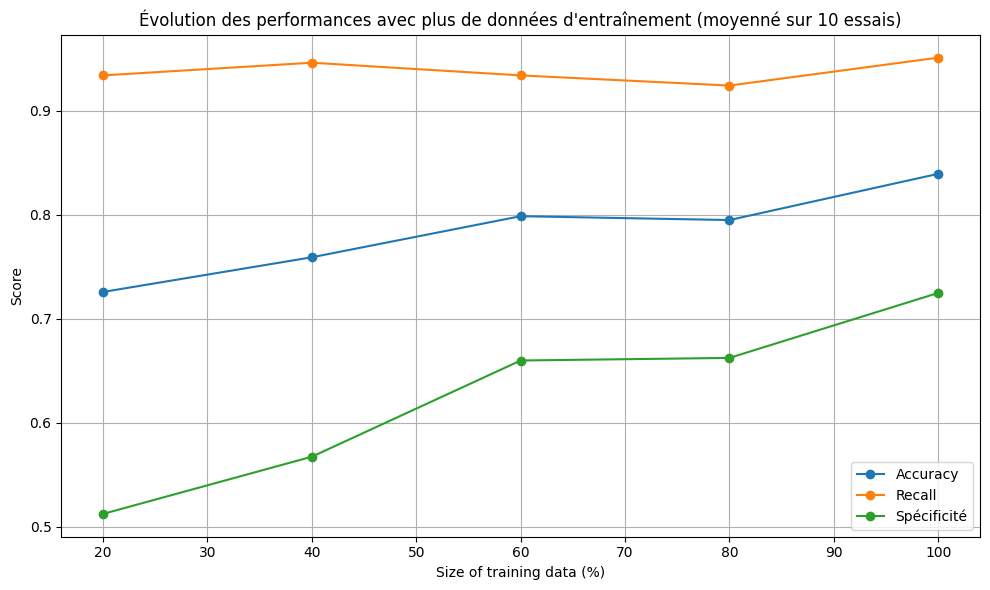

In [18]:
# 📊 Tracé des courbes
plt.figure(figsize=(10, 6))
plt.plot([int(s * 100) for s in train_sizes], accuracies, marker='o', label='Accuracy')
plt.plot([int(s * 100) for s in train_sizes], recalls, marker='o', label='Recall')
plt.plot([int(s * 100) for s in train_sizes], specificities, marker='o', label='Spécificité')
plt.xlabel("Size of training data (%)")
plt.ylabel("Score")
plt.title("Évolution des performances avec plus de données d'entraînement (moyenné sur 10 essais)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# 📚 Training Set Evaluation
# Predict probabilities on the training set
y_proba_train = final_model_full_data.predict_proba(X_train_selected)[:, 1]

# Apply your optimized threshold
y_pred_train = (y_proba_train >= best_thresh_rf).astype(int)

# Compute training metrics
acc_train = accuracy_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_proba_train)

# Confusion matrix for specificity
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
specificity_train = tn_train / (tn_train + fp_train) if (tn_train + fp_train) > 0 else 0

# Display results
print("\n📚 **Training Set Evaluation** 📚")
print(f"Accuracy: {acc_train:.3f}")
print(f"Recall (Sensitivity): {recall_train:.3f}")
print(f"Specificity: {specificity_train:.3f}")
print(f"Precision: {precision_train:.3f}")
print(f"F1 Score: {f1_train:.3f}")
print(f"ROC AUC: {roc_auc_train:.3f}")



📚 **Training Set Evaluation** 📚
Accuracy: 0.846
Recall (Sensitivity): 0.970
Specificity: 0.715
Precision: 0.782
F1 Score: 0.866
ROC AUC: 0.962



✅ **Final Evaluation on Test Set** ✅
Test Accuracy: 0.840
Recall (Sensitivity): 0.951
Specificity (True Negative Rate): 0.7250
Precision: 0.780
F1 Score: 0.857
ROC AUC: 0.921

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82        40
           1       0.78      0.95      0.86        41

    accuracy                           0.84        81
   macro avg       0.86      0.84      0.84        81
weighted avg       0.86      0.84      0.84        81



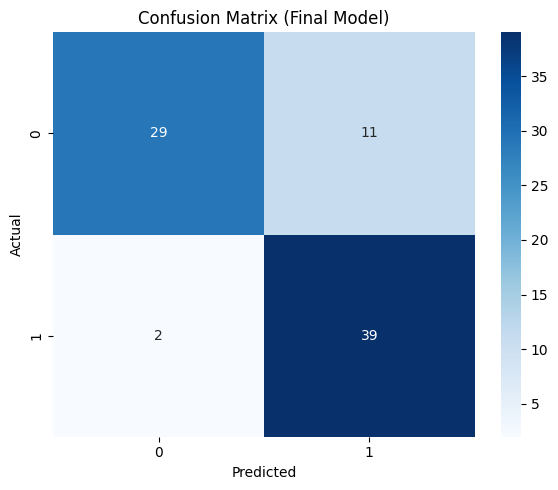

In [22]:
# 📌 Use the previously trained model (100% data, seed 0)
final_model = final_model_full_data  # ← uses the saved model

# 📌 Predictions with the optimized threshold
y_proba_final = final_model.predict_proba(X_test_selected)[:, 1]
y_pred_final = (y_proba_final >= best_thresh_rf).astype(int)

# 📌 Final Metrics
acc_final = accuracy_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)
roc_auc_final = roc_auc_score(y_test, y_proba_final)

# 📌 Confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n✅ **Final Evaluation on Test Set** ✅")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Recall (Sensitivity): {recall_final:.3f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Precision: {precision_final:.3f}")
print(f"F1 Score: {f1_final:.3f}")
print(f"ROC AUC: {roc_auc_final:.3f}")

# 📋 Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['0', '1']))

# 📊 Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title("Confusion Matrix (Final Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Save confusion matrix values uniquely for Random Forest
rf_cm = cm_final
rf_tn, rf_fp, rf_fn, rf_tp = rf_cm.ravel()
specificity_rf = rf_tn / (rf_tn + rf_fp) if (rf_tn + rf_fp) > 0 else 0

In [ ]:
# Save the Random Forest model to a file
joblib.dump(final_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [23]:
# 📌 Clean column names for XGBoost compatibility
def clean_column_names(df):
    """Clean column names to be XGBoost compatible"""
    df_clean = df.copy()
    # Replace problematic characters with underscores
    df_clean.columns = [re.sub(r'[<>\[\],]', '_', str(col)) for col in df_clean.columns]
    # Remove multiple underscores and trailing underscores
    df_clean.columns = [re.sub(r'_+', '_', col).strip('_') for col in df_clean.columns]
    return df_clean

# Clean the full train/test sets (NOT selected features)
X_train_clean = clean_column_names(X_train)
X_test_clean = clean_column_names(X_test)

print("✅ Cleaned column names for XGBoost compatibility")
print(f"Example: {list(X_train.columns[:3])} -> {list(X_train_clean.columns[:3])}")

✅ Cleaned column names for XGBoost compatibility
Example: ['Diagnosis Age', 'Disease Free (Months)', 'Karnofsky Performance Score'] -> ['Diagnosis Age', 'Disease Free (Months)', 'Karnofsky Performance Score']


📊 Step 1: Feature Selection using XGBoost
🔍 12 features: CV score = 0.7593
🔍 15 features: CV score = 0.7716
🔍 20 features: CV score = 0.7593
✅ Best: 15 features with CV score: 0.7716
✅ Top 15 features selected by XGBoost:


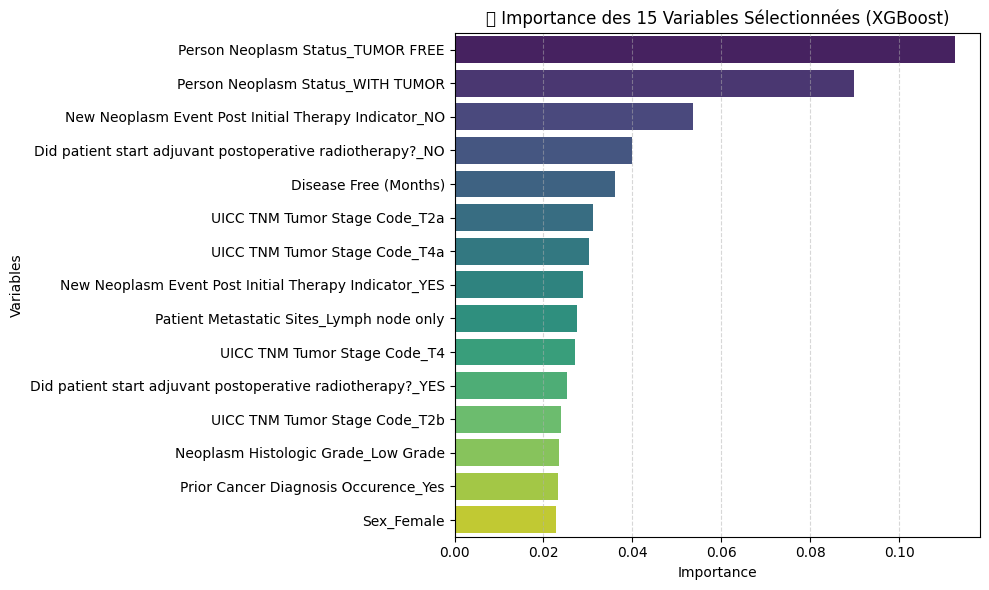

✅ XGBoost selected feature names:
- Person Neoplasm Status_TUMOR FREE
- Person Neoplasm Status_WITH TUMOR
- New Neoplasm Event Post Initial Therapy Indicator_NO
- Did patient start adjuvant postoperative radiotherapy?_NO
- Disease Free (Months)
- UICC TNM Tumor Stage Code_T2a
- UICC TNM Tumor Stage Code_T4a
- New Neoplasm Event Post Initial Therapy Indicator_YES
- Patient Metastatic Sites_Lymph node only
- UICC TNM Tumor Stage Code_T4
- Did patient start adjuvant postoperative radiotherapy?_YES
- UICC TNM Tumor Stage Code_T2b
- Neoplasm Histologic Grade_Low Grade
- Prior Cancer Diagnosis Occurence_Yes
- Sex_Female


In [24]:
print("📊 Step 1: Feature Selection using XGBoost")

# Train initial XGBoost model on full feature set
initial_xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)
initial_xgb_model.fit(X_train_clean, y_train)

# Get feature importances
importances = initial_xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Test different numbers of features and select the best
from sklearn.model_selection import cross_val_score
feature_counts = [12, 15, 20]
best_score = 0
best_n_features = 12

for n_features in feature_counts:
    features = X_train_clean.columns[indices[:n_features]]
    X_temp = X_train_clean[features]
    cv_score = cross_val_score(initial_xgb_model, X_temp, y_train, cv=3, scoring='accuracy').mean()
    print(f"🔍 {n_features} features: CV score = {cv_score:.4f}")
    if cv_score > best_score:
        best_score = cv_score
        best_n_features = n_features

print(f"✅ Best: {best_n_features} features with CV score: {best_score:.4f}")

# Use the best number of features
selected_features_xgb = X_train_clean.columns[indices[:best_n_features]]

print(f"✅ Top {best_n_features} features selected by XGBoost:")
# Get the importances for the selected features
top_importances_xgb = importances[indices[:best_n_features]]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances_xgb, y=selected_features_xgb, palette="viridis")
plt.title(f"🎯 Importance des {best_n_features} Variables Sélectionnées (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Print the feature names
print("✅ XGBoost selected feature names:")
for feature in selected_features_xgb:
    print(f"- {feature}")

# Reduce datasets to selected features
X_train_xgb_selected = X_train_clean[selected_features_xgb]
X_test_xgb_selected = X_test_clean[selected_features_xgb]

# Fix: Use the correct variable name
selected_features_clean = selected_features_xgb  # This was the missing variable


In [25]:
# 📌 7. XGBoost Advanced Hyperparameter Grid (Best Practices)
print("\n📊 Step 2: Advanced XGBoost Hyperparameter Grid Search")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],             # Keep moderate values
    'max_depth': [3, 5],                         # Lower depth to reduce overfitting
    'learning_rate': [0.01, 0.05],               # Conservative learning rates
    'subsample': [0.7, 0.8, 1.0],                # Slightly more regularization
    'colsample_bytree': [0.7, 0.8],              # Reduced features per tree
    'gamma': [0.1, 0.2, 0.3],                    # Encourage pruning of branches
    'min_child_weight': [3, 5],                  # Increase to avoid small splits
    'reg_alpha': [0.1, 0.5],                     # Stronger L1 penalty
    'reg_lambda': [1, 2],                        # L2 regularization
    'scale_pos_weight': [1]                      # Still 1 unless class imbalance is significant
}


# 📌 8. GridSearchCV for XGBoost
base_xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0)
scoring_xgb = {
    'roc_auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score)
}

# Fix: Use the correct variable name
X_train_selected_clean = X_train_xgb_selected
X_test_selected_clean = X_test_xgb_selected

xgb_grid_search = GridSearchCV(
    estimator=base_xgb_model,
    param_grid=xgb_param_grid,
    cv=5,
    scoring=scoring_xgb,
    refit='roc_auc',
    n_jobs=-1,
    verbose=2
)
xgb_grid_search.fit(X_train_selected_clean, y_train)
best_xgb_model = xgb_grid_search.best_estimator_

print("✅ Meilleurs paramètres XGBoost trouvés :", xgb_grid_search.best_params_)



📊 Step 2: Advanced XGBoost Hyperparameter Grid Search
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
✅ Meilleurs paramètres XGBoost trouvés : {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1.0}



📈 Step 5: ROC Curve & Threshold Analysis for Final XGBoost Model


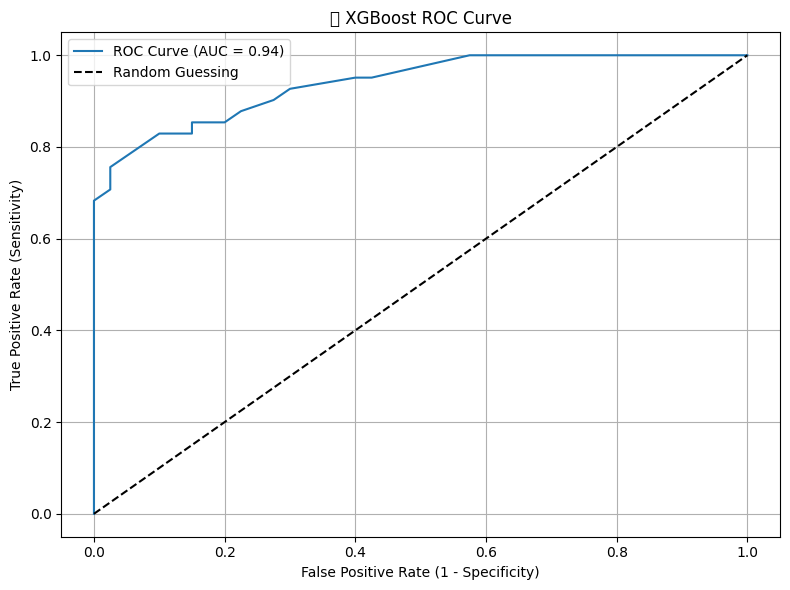


✅ Best threshold found: 0.3760
🔹 Sensitivity (Test): 0.9512
🔹 Specificity (Test): 0.6000


In [26]:
print("\n📈 Step 5: ROC Curve & Threshold Analysis for Final XGBoost Model")

# Use the best XGBoost model from GridSearch
final_xgb_model = clone(best_xgb_model)
final_xgb_model.fit(X_train_selected_clean, y_train)

# Predicted probabilities on test and train sets
y_proba_test = final_xgb_model.predict_proba(X_test_selected_clean)[:, 1]
y_proba_train = final_xgb_model.predict_proba(X_train_selected_clean)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba_test):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('🔥 XGBoost ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 Threshold Optimization: Maximize sensitivity with specificity ≥ 60%
best_thresh_xgb = None
best_sens = 0
best_spec = 0

for thresh in thresholds:
    y_pred = (y_proba_test >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    if specificity >= 0.60 and sensitivity > best_sens:
        best_thresh_xgb = thresh
        best_sens = sensitivity
        best_spec = specificity

# Final threshold output
if best_thresh_xgb is not None:
    print(f"\n✅ Best threshold found: {best_thresh_xgb:.4f}")
    print(f"🔹 Sensitivity (Test): {best_sens:.4f}")
    print(f"🔹 Specificity (Test): {best_spec:.4f}")
else:
    print("\n❌ No threshold found that satisfies: specificity ≥ 60%")
    best_thresh_xgb = 0.5


📊 Step 3: Detailed Parameter Analysis
Calculating detailed metrics for all XGBoost parameter combinations...


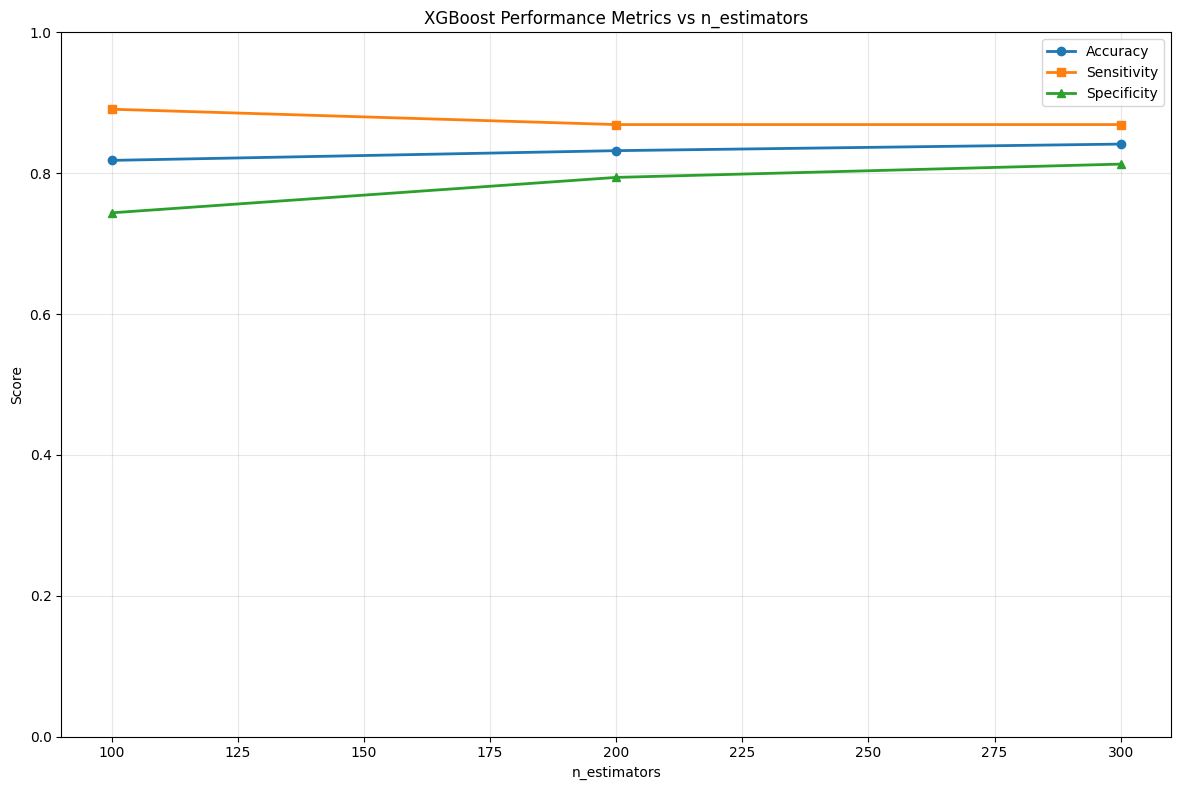

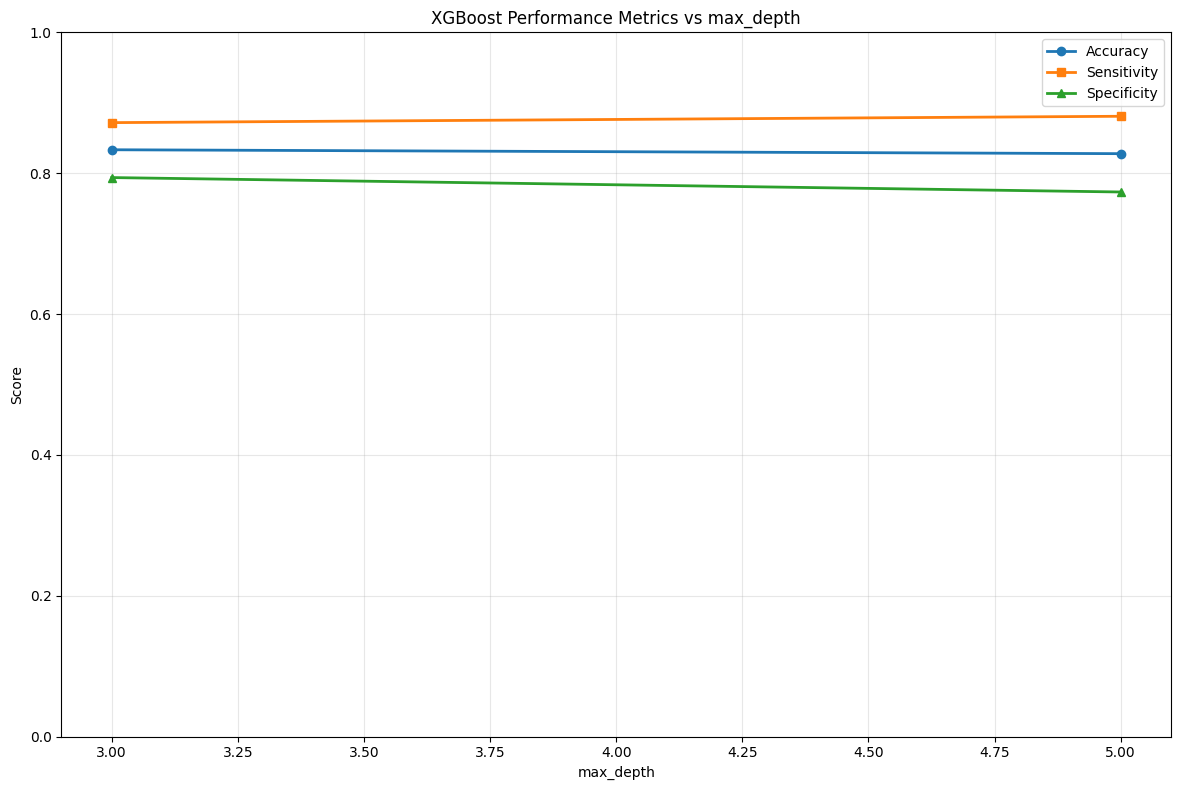

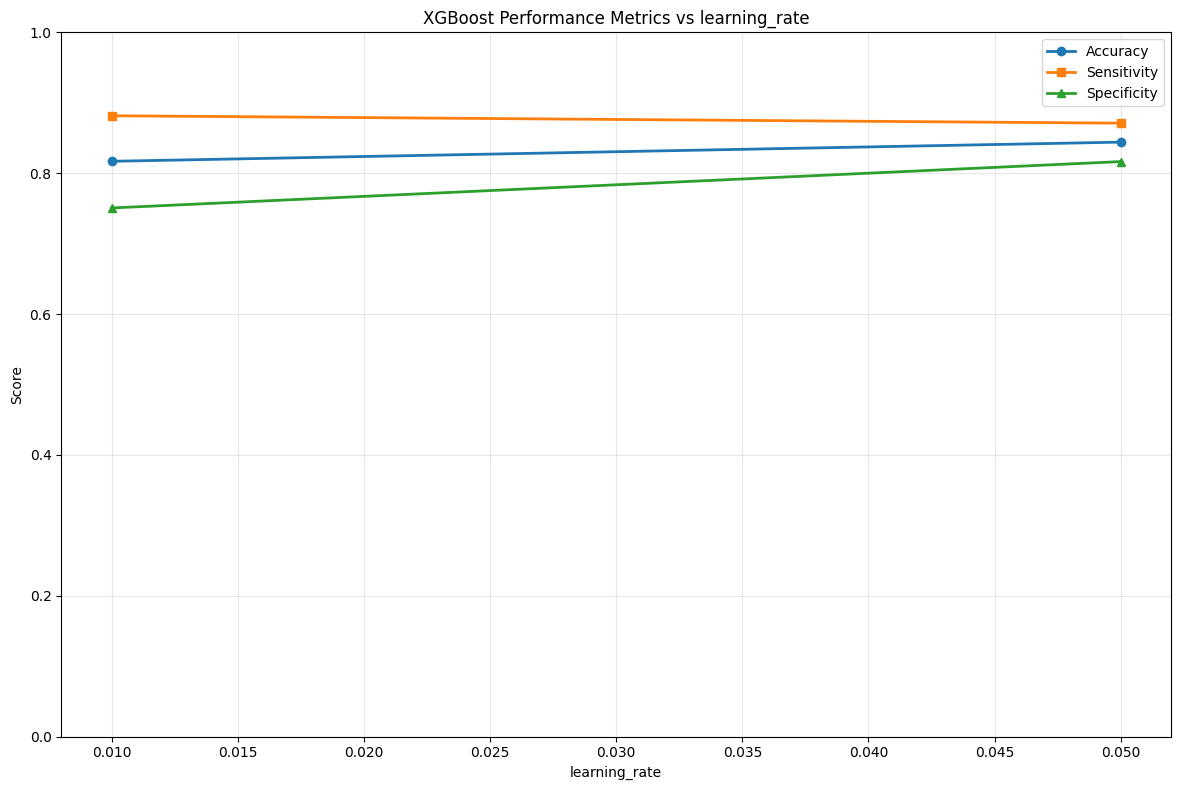

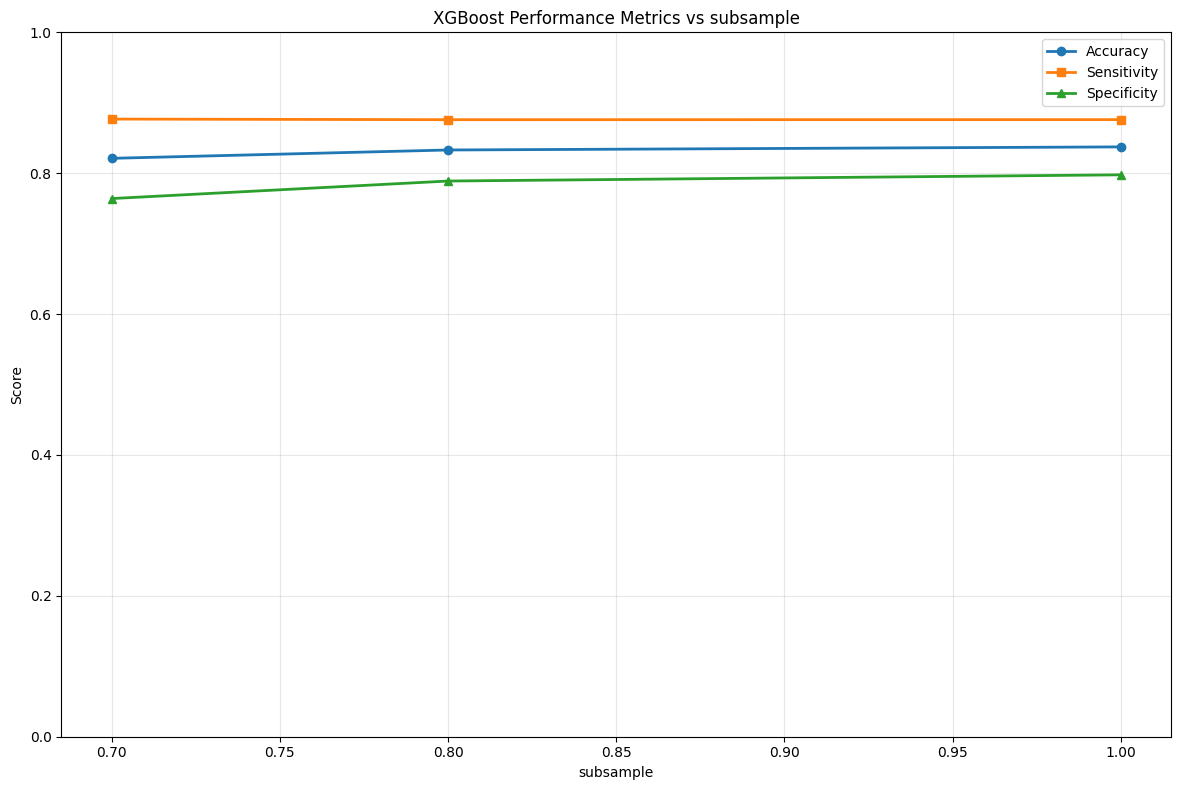

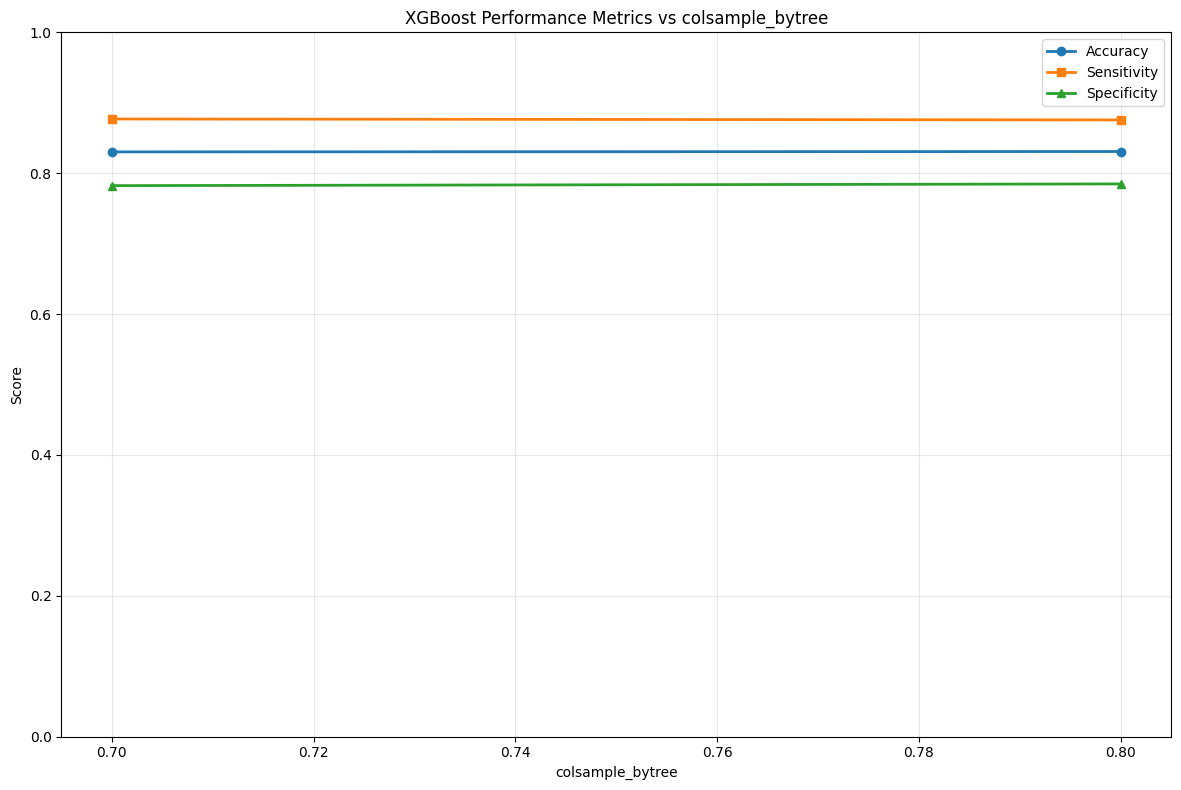

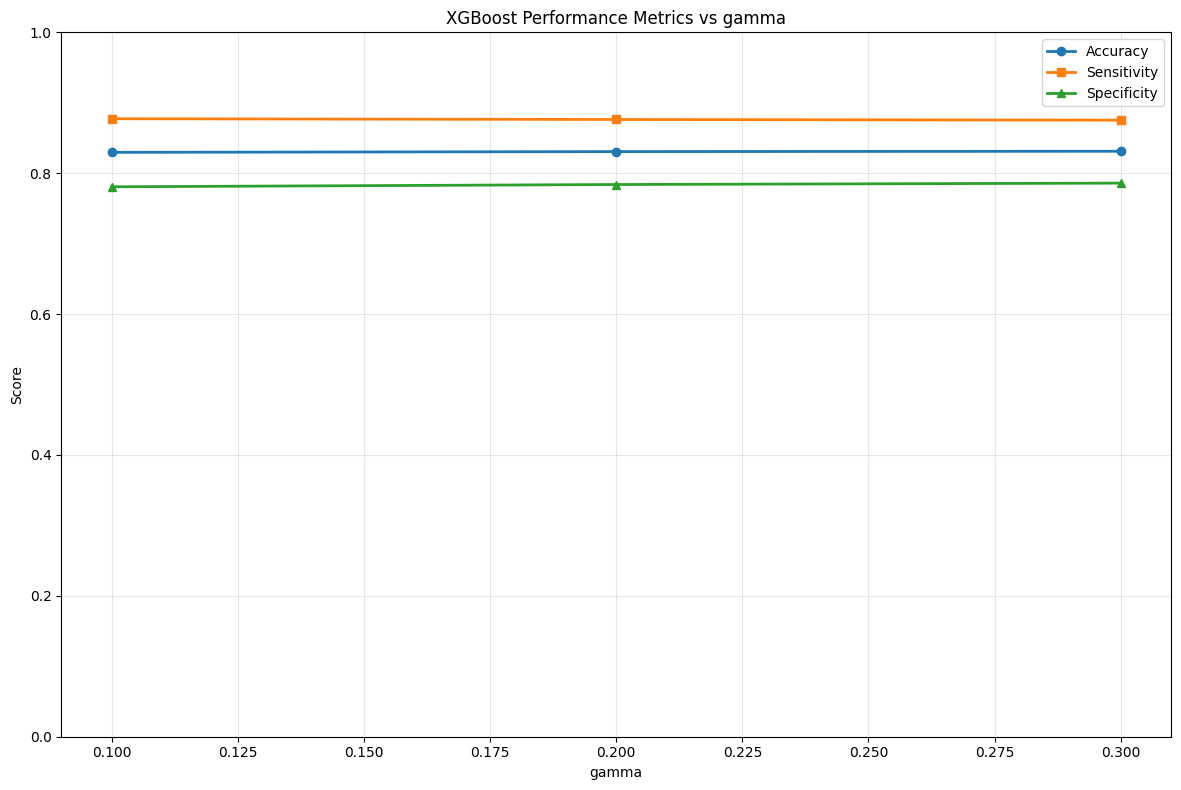

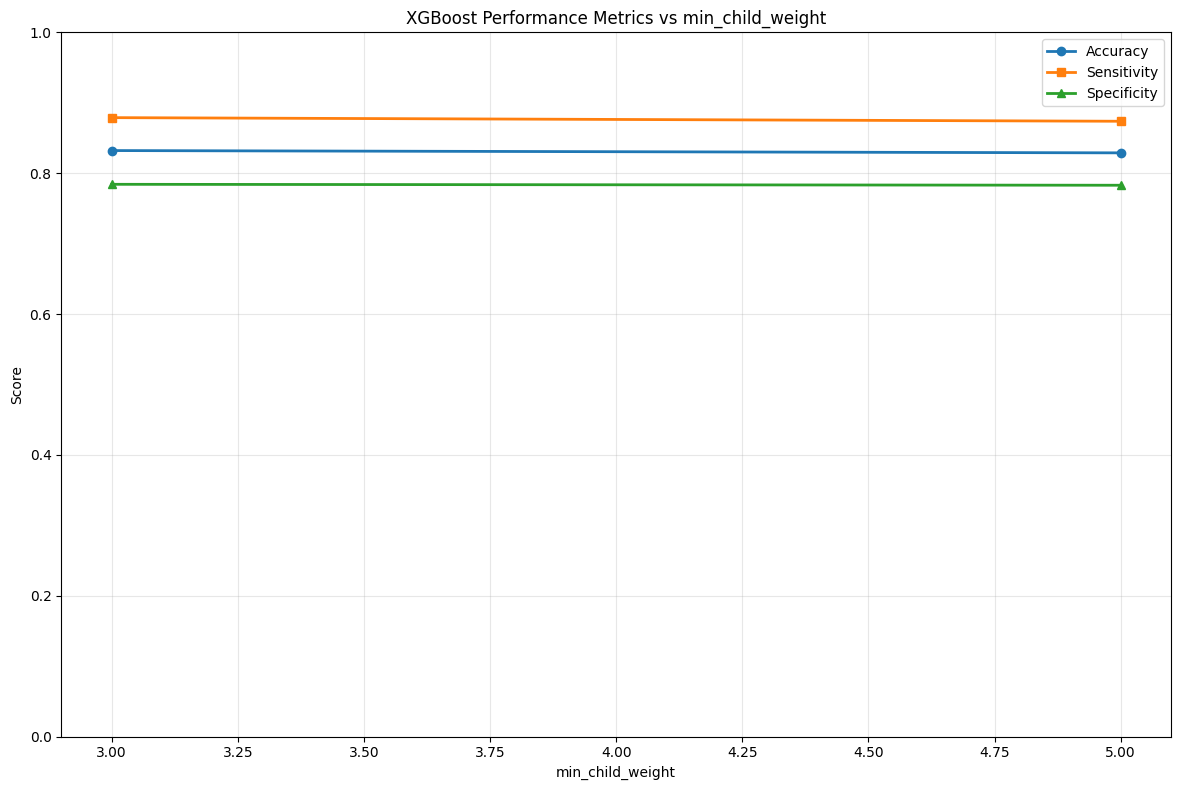

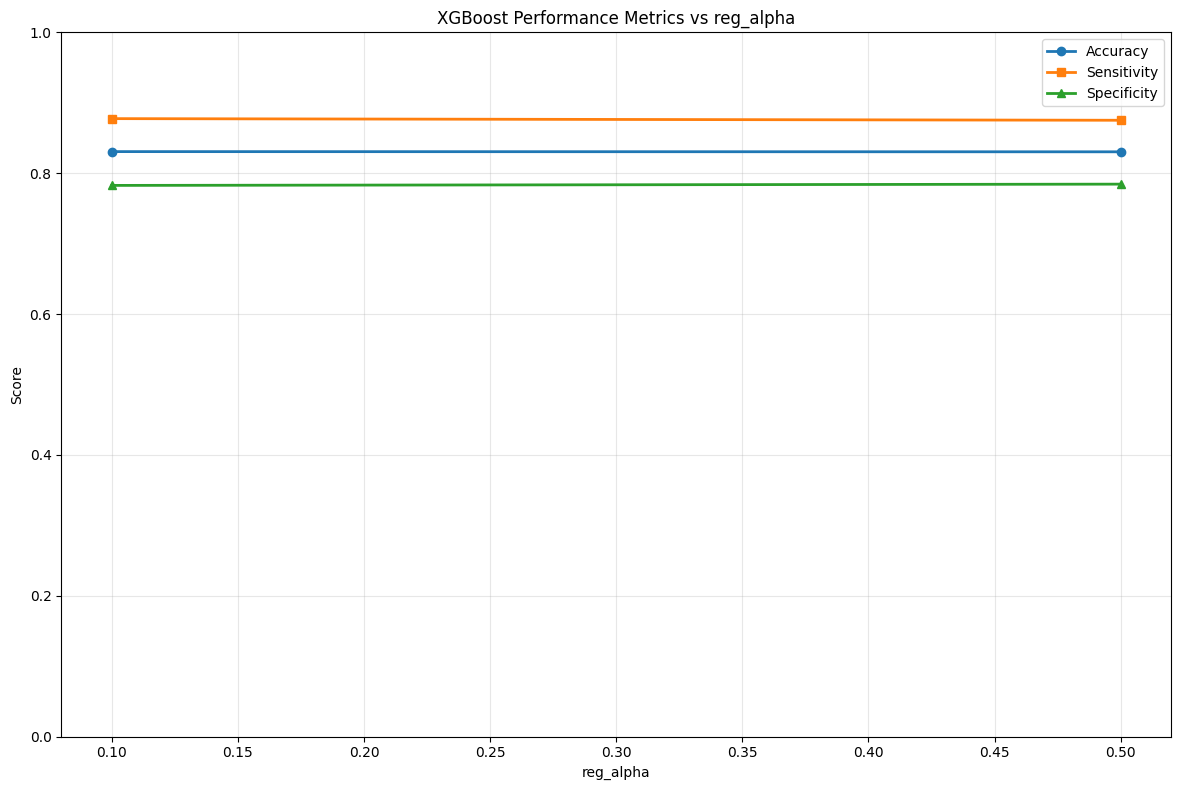


📋 Best XGBoost parameter combinations for each metric:

🎯 Best Accuracy:
Accuracy: 0.877
n_estimators: 300
max_depth: 5
learning_rate: 0.01
subsample: 1.0
colsample_bytree: 0.7
gamma: 0.1
min_child_weight: 3
reg_alpha: 0.1

🎯 Best Sensitivity:
Sensitivity: 0.951
n_estimators: 100
max_depth: 3
learning_rate: 0.01
subsample: 0.7
colsample_bytree: 0.7
gamma: 0.1
min_child_weight: 3
reg_alpha: 0.1

🎯 Best Specificity:
Specificity: 0.875
n_estimators: 300
max_depth: 3
learning_rate: 0.01
subsample: 0.8
colsample_bytree: 0.7
gamma: 0.1
min_child_weight: 3
reg_alpha: 0.1

📈 XGBoost Parameter impact summary (correlation with metrics):
          Parameter  Accuracy_Corr  Sensitivity_Corr  Specificity_Corr
0      n_estimators          0.367            -0.358             0.408
1         max_depth         -0.108             0.181            -0.148
2     learning_rate          0.529            -0.211             0.476
3         subsample          0.240            -0.011             0.185
4  colsam

In [27]:
# 📊 Detailed Results Analysis
print("\n📊 Step 3: Detailed Parameter Analysis")
xgb_detailed_results = []

print("Calculating detailed metrics for all XGBoost parameter combinations...")
for i, params in enumerate(xgb_grid_search.cv_results_['params']):
    # Create XGBoost model with these parameters
    model = XGBClassifier(**params, random_state=42, eval_metric='logloss', verbosity=0)
    model.fit(X_train_selected_clean, y_train)

    # Get predictions with same custom threshold
    y_proba = model.predict_proba(X_test_selected_clean)[:, 1]
    y_pred = (y_proba >= best_thresh_xgb).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)

    # Calculate specificity
    cm = confusion_matrix(y_test, y_pred)
    tn, fp = cm[0, 0], cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Store results
    result = params.copy()
    result.update({
        'accuracy': acc,
        'sensitivity': sensitivity,
        'specificity': specificity
    })
    xgb_detailed_results.append(result)

# Convert to DataFrame
xgb_detailed_df = pd.DataFrame(xgb_detailed_results)

# 📈 Plot for each XGBoost hyperparameter
xgb_hyperparameters = ['n_estimators', 'max_depth', 'learning_rate', 'subsample',
                       'colsample_bytree', 'gamma', 'min_child_weight', 'reg_alpha']

for param in xgb_hyperparameters:
    plt.figure(figsize=(12, 8))

    # Get unique values for this parameter
    unique_values = sorted(xgb_detailed_df[param].unique())

    # Group by parameter value and calculate mean metrics
    metrics_by_param = xgb_detailed_df.groupby(param)[['accuracy', 'sensitivity', 'specificity']].mean()

    # All plots will now be curves (line plots)
    plt.plot(metrics_by_param.index, metrics_by_param['accuracy'], marker='o', label='Accuracy', linewidth=2)
    plt.plot(metrics_by_param.index, metrics_by_param['sensitivity'], marker='s', label='Sensitivity', linewidth=2)
    plt.plot(metrics_by_param.index, metrics_by_param['specificity'], marker='^', label='Specificity', linewidth=2)

    plt.xlabel(param)
    plt.ylabel('Score')
    plt.title(f'XGBoost Performance Metrics vs {param}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.ylim(0, 1)
    plt.show()

# 📊 Summary table of best combinations for each metric
print("\n📋 Best XGBoost parameter combinations for each metric:")
print("\n🎯 Best Accuracy:")
best_acc_idx = xgb_detailed_df['accuracy'].idxmax()
print(f"Accuracy: {xgb_detailed_df.loc[best_acc_idx, 'accuracy']:.3f}")
for param in xgb_hyperparameters:
    print(f"{param}: {xgb_detailed_df.loc[best_acc_idx, param]}")

print("\n🎯 Best Sensitivity:")
best_sens_idx = xgb_detailed_df['sensitivity'].idxmax()
print(f"Sensitivity: {xgb_detailed_df.loc[best_sens_idx, 'sensitivity']:.3f}")
for param in xgb_hyperparameters:
    print(f"{param}: {xgb_detailed_df.loc[best_sens_idx, param]}")

print("\n🎯 Best Specificity:")
best_spec_idx = xgb_detailed_df['specificity'].idxmax()
print(f"Specificity: {xgb_detailed_df.loc[best_spec_idx, 'specificity']:.3f}")
for param in xgb_hyperparameters:
    print(f"{param}: {xgb_detailed_df.loc[best_spec_idx, param]}")

# 📊 Parameter correlation with metrics (for numeric parameters)
print("\n📈 XGBoost Parameter impact summary (correlation with metrics):")
xgb_correlation_summary = []
numeric_params = ['n_estimators', 'max_depth', 'learning_rate', 'subsample',
                  'colsample_bytree', 'gamma', 'min_child_weight', 'reg_alpha']
for param in numeric_params:
    corr_acc = xgb_detailed_df[param].corr(xgb_detailed_df['accuracy'])
    corr_sens = xgb_detailed_df[param].corr(xgb_detailed_df['sensitivity'])
    corr_spec = xgb_detailed_df[param].corr(xgb_detailed_df['specificity'])

    xgb_correlation_summary.append({
        'Parameter': param,
        'Accuracy_Corr': corr_acc,
        'Sensitivity_Corr': corr_sens,
        'Specificity_Corr': corr_spec
    })

xgb_corr_df = pd.DataFrame(xgb_correlation_summary)
print(xgb_corr_df.round(3))

In [28]:
# 📈 Training Size Analysis
print("\n📊 Step 4: Training Size Analysis")
train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
xgb_accuracies = []
xgb_recalls = []
xgb_specificities = []

final_xgb_model_full_data = None

print("\nRésultats XGBoost pour chaque taille de données d'entraînement :\n")

for size in train_sizes:
    acc_temp, rec_temp, spec_temp = [], [], []

    for seed in range(10):
        if size < 1.0:
            X_train_part, _, y_train_part, _ = train_test_split(
                X_train_selected_clean, y_train, train_size=size, random_state=seed
            )
        else:
            X_train_part = X_train_selected_clean
            y_train_part = y_train

        model = clone(best_xgb_model)
        model.fit(X_train_part, y_train_part)

        # Save model trained with 100% of the data and seed 0
        if size == 1.0 and seed == 0:
            final_xgb_model_full_data = model

        # Probabilités + seuil personnalisé
        y_proba = model.predict_proba(X_test_selected_clean)[:, 1]
        y_pred = (y_proba >= best_thresh_xgb).astype(int)

        acc_temp.append(accuracy_score(y_test, y_pred))
        rec_temp.append(recall_score(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        TN = cm[0, 0]
        FP = cm[0, 1]
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        spec_temp.append(spec)

    acc_mean = np.mean(acc_temp)
    rec_mean = np.mean(rec_temp)
    spec_mean = np.mean(spec_temp)

    xgb_accuracies.append(acc_mean)
    xgb_recalls.append(rec_mean)
    xgb_specificities.append(spec_mean)

    print(f"Taille {int(size * 100)}% : Accuracy = {acc_mean:.3f} | Recall = {rec_mean:.3f} | Spécificité = {spec_mean:.3f}")



📊 Step 4: Training Size Analysis

Résultats XGBoost pour chaque taille de données d'entraînement :

Taille 20% : Accuracy = 0.627 | Recall = 0.966 | Spécificité = 0.280
Taille 40% : Accuracy = 0.772 | Recall = 0.929 | Spécificité = 0.610
Taille 60% : Accuracy = 0.777 | Recall = 0.939 | Spécificité = 0.610
Taille 80% : Accuracy = 0.793 | Recall = 0.905 | Spécificité = 0.677
Taille 100% : Accuracy = 0.778 | Recall = 0.951 | Spécificité = 0.600


In [29]:
# 📌 XGBoost Evaluation on Training Set
print("\n🔍 XGBoost Evaluation on Training Set")

# Use the final trained model on 100% data (seed 0)
final_xgb_model = final_xgb_model_full_data

# Predict probabilities and labels on training set
y_proba_train_xgb = final_xgb_model.predict_proba(X_train_selected_clean)[:, 1]
y_pred_train_xgb = (y_proba_train_xgb >= best_thresh_xgb).astype(int)

# Metrics on training set
acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
recall_train_xgb = recall_score(y_train, y_pred_train_xgb)
precision_train_xgb = precision_score(y_train, y_pred_train_xgb)
f1_train_xgb = f1_score(y_train, y_pred_train_xgb)
roc_auc_train_xgb = roc_auc_score(y_train, y_proba_train_xgb)

# Confusion matrix and specificity
tn_train_xgb, fp_train_xgb, fn_train_xgb, tp_train_xgb = confusion_matrix(y_train, y_pred_train_xgb).ravel()
specificity_train_xgb = tn_train_xgb / (tn_train_xgb + fp_train_xgb) if (tn_train_xgb + fp_train_xgb) > 0 else 0

# Print results
print(f"Accuracy: {acc_train_xgb:.3f}")
print(f"Recall (Sensitivity): {recall_train_xgb:.3f}")
print(f"Specificity (True Negative Rate): {specificity_train_xgb:.3f}")
print(f"Precision: {precision_train_xgb:.3f}")
print(f"F1 Score: {f1_train_xgb:.3f}")
print(f"ROC AUC: {roc_auc_train_xgb:.3f}")



🔍 XGBoost Evaluation on Training Set
Accuracy: 0.765
Recall (Sensitivity): 0.934
Specificity (True Negative Rate): 0.589
Precision: 0.705
F1 Score: 0.803
ROC AUC: 0.898



📊 Step 5: Final Model Evaluation

✅ **Final XGBoost Evaluation on Test Set** ✅
Test Accuracy: 0.778
Recall (Sensitivity): 0.951
Specificity (True Negative Rate): 0.6000
Precision: 0.709
F1 Score: 0.812
ROC AUC: 0.939

📋 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73        40
           1       0.71      0.95      0.81        41

    accuracy                           0.78        81
   macro avg       0.82      0.78      0.77        81
weighted avg       0.81      0.78      0.77        81



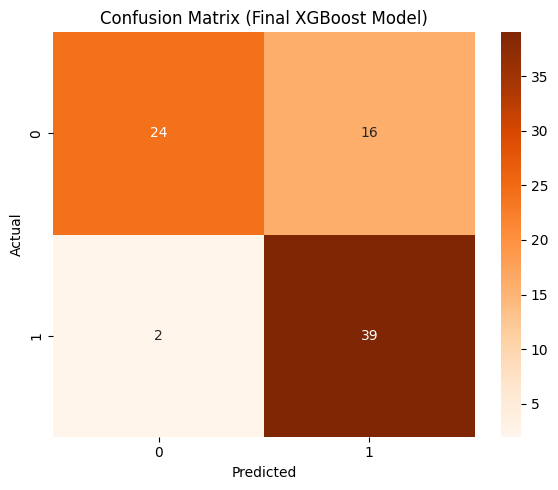

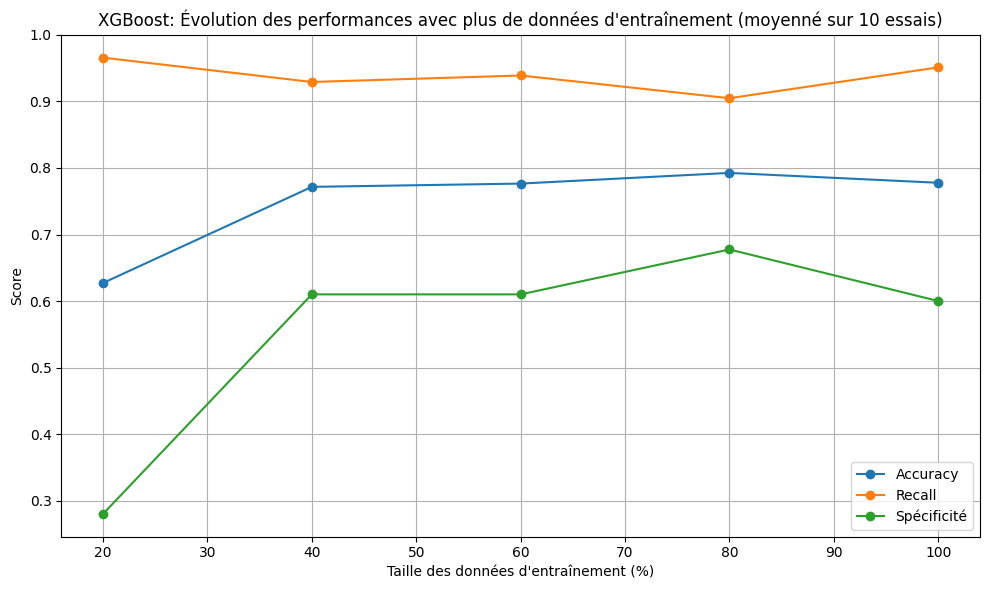


🎉 XGBoost Analysis Complete!


In [30]:
# 📌 Final XGBoost Evaluation
print("\n📊 Step 5: Final Model Evaluation")
final_xgb_model = final_xgb_model_full_data
# Predictions on TEST SET with the optimized threshold
y_proba_final_xgb = final_xgb_model.predict_proba(X_test_selected_clean)[:, 1]
y_pred_final_xgb = (y_proba_final_xgb >= best_thresh_xgb).astype(int)

# Final Metrics
acc_final_xgb = accuracy_score(y_test, y_pred_final_xgb)
recall_final_xgb = recall_score(y_test, y_pred_final_xgb)
precision_final_xgb = precision_score(y_test, y_pred_final_xgb)
f1_final_xgb = f1_score(y_test, y_pred_final_xgb)
roc_auc_final_xgb = roc_auc_score(y_test, y_proba_final_xgb)

# Confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final_xgb).ravel()
specificity_xgb = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n✅ **Final XGBoost Evaluation on Test Set** ✅")
print(f"Test Accuracy: {acc_final_xgb:.3f}")
print(f"Recall (Sensitivity): {recall_final_xgb:.3f}")
print(f"Specificity (True Negative Rate): {specificity_xgb:.4f}")
print(f"Precision: {precision_final_xgb:.3f}")
print(f"F1 Score: {f1_final_xgb:.3f}")
print(f"ROC AUC: {roc_auc_final_xgb:.3f}")

# Classification Report
print("\n📋 XGBoost Classification Report:")
print(classification_report(y_test, y_pred_final_xgb, target_names=['0', '1']))

# Confusion Matrix
cm_final_xgb = confusion_matrix(y_test, y_pred_final_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title("Confusion Matrix (Final XGBoost Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Save XGBoost confusion matrix values explicitly
xgb_cm = cm_final_xgb
xgb_tn, xgb_fp, xgb_fn, xgb_tp = xgb_cm.ravel()
specificity_xgb = xgb_tn / (xgb_tn + xgb_fp) if (xgb_tn + xgb_fp) > 0 else 0

# 📊 Training Size Performance Plot
plt.figure(figsize=(10, 6))
plt.plot([int(s * 100) for s in train_sizes], xgb_accuracies, marker='o', label='Accuracy')
plt.plot([int(s * 100) for s in train_sizes], xgb_recalls, marker='o', label='Recall')
plt.plot([int(s * 100) for s in train_sizes], xgb_specificities, marker='o', label='Spécificité')
plt.xlabel("Taille des données d'entraînement (%)")
plt.ylabel("Score")
plt.title("XGBoost: Évolution des performances avec plus de données d'entraînement (moyenné sur 10 essais)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n🎉 XGBoost Analysis Complete!")
print("=" * 60)

In [31]:
print("🔥 SVM ANALYSIS STARTING")
print("="*60)

# 📌 Data Preprocessing for SVM (Scaling is crucial for SVM)
print("📊 Step 1: Data Preprocessing and Feature Scaling")
svm_scaler = StandardScaler()
X_train_svm_scaled = pd.DataFrame(
    svm_scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_svm_scaled = pd.DataFrame(
    svm_scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"✅ Data scaled successfully")
print(f"Training set shape: {X_train_svm_scaled.shape}")
print(f"Test set shape: {X_test_svm_scaled.shape}")

🔥 SVM ANALYSIS STARTING
📊 Step 1: Data Preprocessing and Feature Scaling
✅ Data scaled successfully
Training set shape: (324, 202)
Test set shape: (81, 202)



📊 Step 2: Feature Selection using SVM
Best number of features: 12 (CV score: 0.7500)
✅ Selected top 12 features using Linear SVM
Selected features: ['Person Neoplasm Status_WITH TUMOR', 'Person Neoplasm Status_TUMOR FREE', 'UICC TNM Tumor Stage Code_T3', 'Prostate Cancer UICC TNM Stage_pT1a', 'UICC TNM Tumor Stage Code_T4', 'Prostate Cancer UICC TNM Stage_pT3a', 'Family History Cancer Relationship_Grandfather|Sister', 'Diagnosis Age', 'Family History Cancer Relationship_Grandmother', 'Family History Cancer Relationship_Sister', 'Disease Free (Months)', 'UICC TNM Tumor Stage Code_T2a']


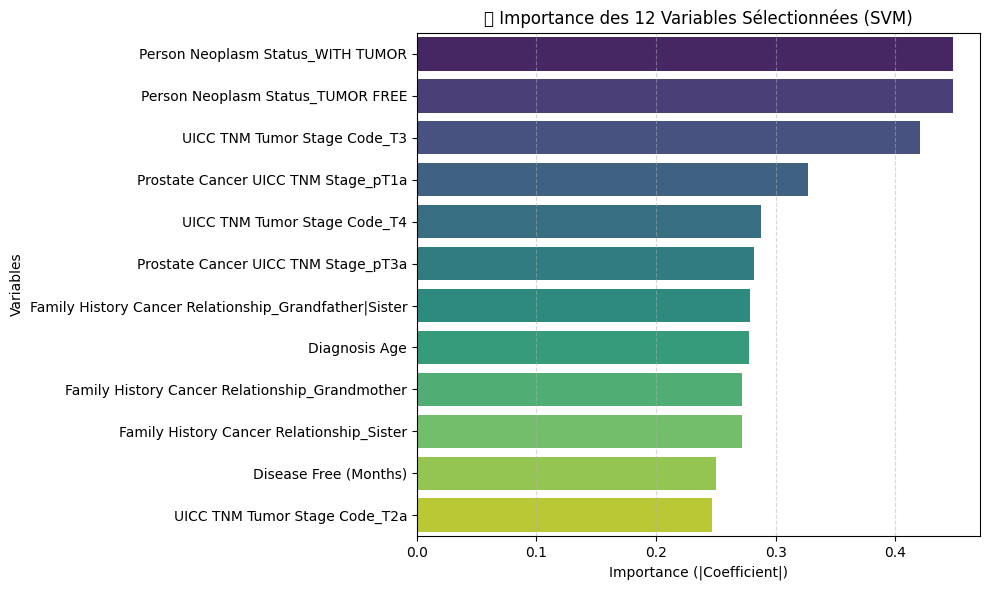

In [32]:
# 📌 6. Feature Selection using SVM (Auto-select best from 12, 15, 20)
print("\n📊 Step 2: Feature Selection using SVM")

# Use Linear SVM for feature selection (faster and good for feature importance)
linear_svm_selector = SVC(kernel='linear', C=1.0, random_state=42)
linear_svm_selector.fit(X_train_svm_scaled, y_train)

# Get feature importance from linear SVM coefficients
svm_feature_importance = np.abs(linear_svm_selector.coef_[0])
svm_feature_names = X_train_svm_scaled.columns

# Create feature importance dataframe and sort
svm_importance_df = pd.DataFrame({
    'feature': svm_feature_names,
    'importance': svm_feature_importance
}).sort_values('importance', ascending=False)

# Test 12, 15, 20 features and pick the best
feature_counts = [12, 15, 20]
best_score = 0
best_n_features = 12

for n_features in feature_counts:
    selected_features = svm_importance_df.head(n_features)['feature'].tolist()
    X_temp = X_train_svm_scaled[selected_features]

    # Quick CV test
    svm_test = SVC(kernel='rbf', random_state=42)
    cv_score = cross_val_score(svm_test, X_temp, y_train, cv=3).mean()

    if cv_score > best_score:
        best_score = cv_score
        best_n_features = n_features

print(f"Best number of features: {best_n_features} (CV score: {best_score:.4f})")

# Select top features based on best result
selected_features_svm = svm_importance_df.head(best_n_features)['feature'].tolist()
top_svm_importances = svm_importance_df.head(best_n_features)['importance'].values

# Create selected datasets
X_train_selected_svm = X_train_svm_scaled[selected_features_svm]
X_test_selected_svm = X_test_svm_scaled[selected_features_svm]

print(f"✅ Selected top {best_n_features} features using Linear SVM")
print(f"Selected features: {selected_features_svm}")

# 📊 Feature Importance Plot for SVM
plt.figure(figsize=(10, 6))
sns.barplot(x=top_svm_importances, y=selected_features_svm, palette="viridis")
plt.title(f"🎯 Importance des {best_n_features} Variables Sélectionnées (SVM)")
plt.xlabel("Importance (|Coefficient|)")
plt.ylabel("Variables")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [33]:
# 📌 7. SVM Hyperparameter Grid (Comprehensive for RBF and Linear)
print("\n📊 Step 3: SVM Hyperparameter Grid Search")
svm_param_grid = {
    'C': [0.1, 1, 10, 100],                    # Reduced from 5 to 4 values
    'kernel': ['linear', 'rbf'],               # Removed 'poly' (usually less effective)
    'gamma': ['scale', 0.01, 0.1, 1],        # Reduced from 6 to 4 values
    'class_weight': ['balanced', None]         # Keep both for imbalance handling
}

# 📌 8. GridSearchCV for SVM with Calibration
print("🔧 Setting up SVM Grid Search with Calibration...")

# Base SVM model
base_svm_model = SVC(random_state=42, probability=True)  # probability=True for calibration

svm_scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score)
}

svm_grid_search = GridSearchCV(
    estimator=base_svm_model,
    param_grid=svm_param_grid,
    cv=5,
    scoring=svm_scoring,
    refit='roc_auc',
    n_jobs=-1,
    verbose=2
)

svm_grid_search.fit(X_train_selected_svm, y_train)
best_svm_model = svm_grid_search.best_estimator_

print("✅ Meilleurs paramètres SVM trouvés :", svm_grid_search.best_params_)


📊 Step 3: SVM Hyperparameter Grid Search
🔧 Setting up SVM Grid Search with Calibration...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
✅ Meilleurs paramètres SVM trouvés : {'C': 100, 'class_weight': None, 'gamma': 0.01, 'kernel': 'rbf'}


In [34]:
# 📌 Calibration of the best SVM model
print("\n🎯 Step 4: SVM Model Calibration")
calibrated_svm = CalibratedClassifierCV(best_svm_model, method='isotonic', cv=3)
calibrated_svm.fit(X_train_selected_svm, y_train)
print("✅ SVM model calibrated successfully")


🎯 Step 4: SVM Model Calibration
✅ SVM model calibrated successfully



📈 Step 5: ROC Curve Analysis


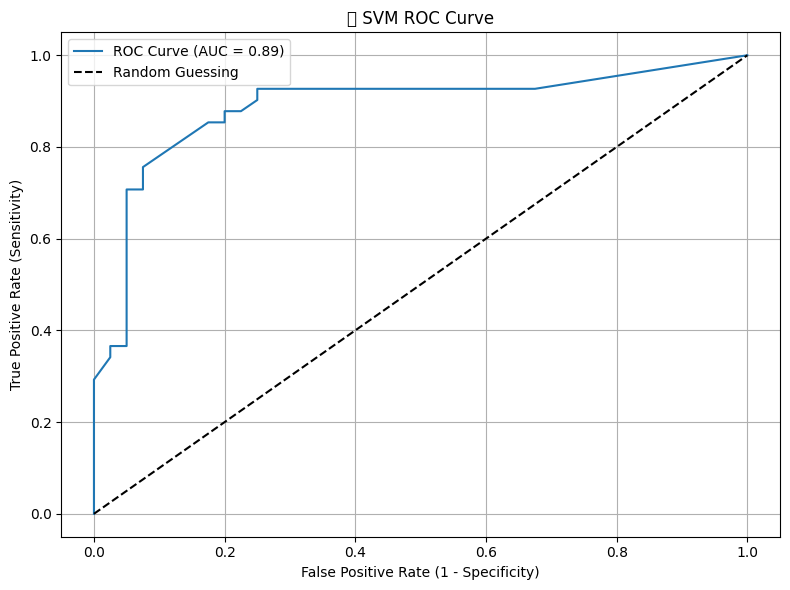

📊 Training Accuracy: 0.8148

✅ Best threshold found: 0.3649
🔹 Sensitivity (Test): 0.9268
🔹 Specificity (Test): 0.7500


In [35]:
print("\n📈 Step 5: ROC Curve Analysis")

# Get predicted probabilities on the test set
y_proba_test_svm = calibrated_svm.predict_proba(X_test_selected_svm)[:, 1]
y_proba_train_svm = calibrated_svm.predict_proba(X_train_selected_svm)[:, 1]

# ROC Curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_proba_test_svm)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_test_svm)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('🔥 SVM ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

train_accuracy_svm = accuracy_score(y_train, (y_proba_train_svm >= 0.5).astype(int))
print(f"📊 Training Accuracy: {train_accuracy_svm:.4f}")

# Find best threshold: maximize sensitivity with specificity ≥ 60%
best_threshold_svm = None
best_sens_svm = 0
best_spec_svm = 0

for thresh in thresholds_svm:
    y_pred_svm = (y_proba_test_svm >= thresh).astype(int)
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    tn, fp, fn, tp = cm_svm.ravel()

    sensitivity_svm = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity_svm = tn / (tn + fp) if (tn + fp) > 0 else 0

    if specificity_svm >= 0.60 and sensitivity_svm > best_sens_svm:
        best_sens_svm = sensitivity_svm
        best_spec_svm = specificity_svm
        best_threshold_svm = thresh

# Final output
if best_threshold_svm is not None:
    print(f"\n✅ Best threshold found: {best_threshold_svm:.4f}")
    print(f"🔹 Sensitivity (Test): {best_sens_svm:.4f}")
    print(f"🔹 Specificity (Test): {best_spec_svm:.4f}")
else:
    print("\n❌ No threshold found that satisfies: specificity ≥ 60%")



📊 Step 5: Detailed Parameter Analysis
Calculating detailed metrics for all SVM parameter combinations...
Processed 50/64 combinations...


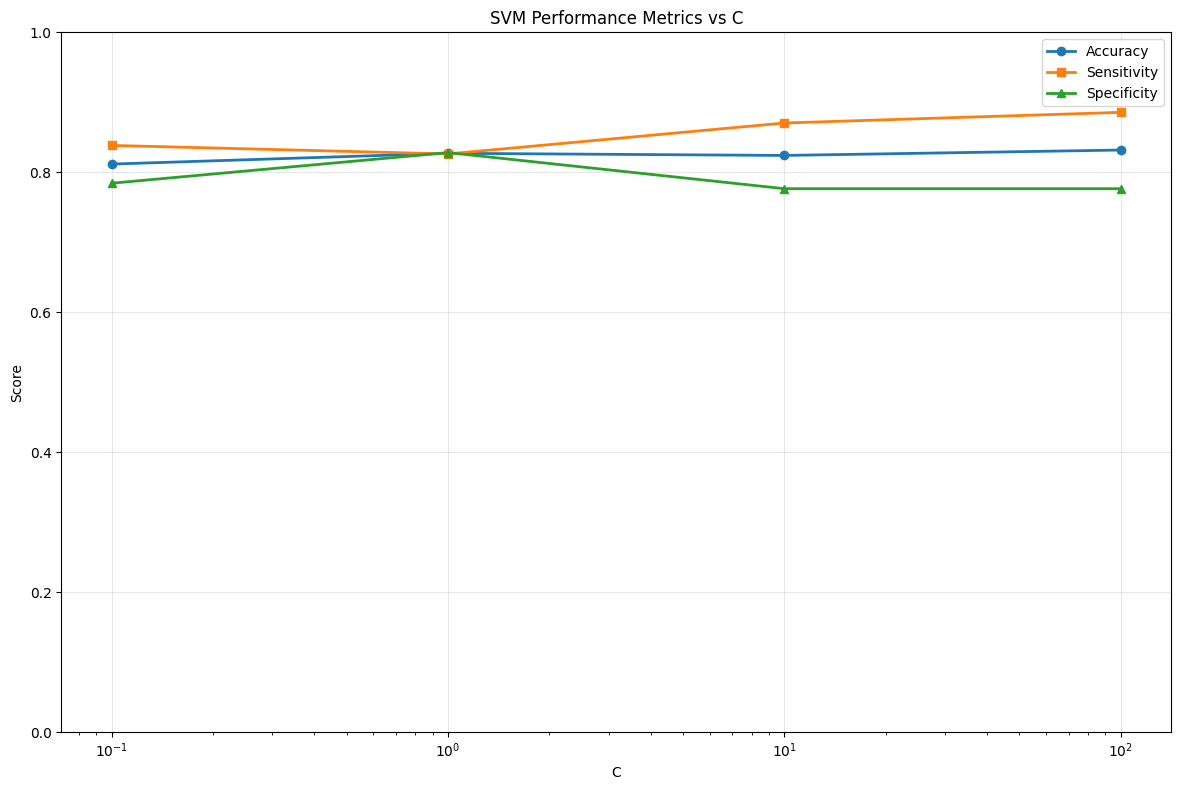

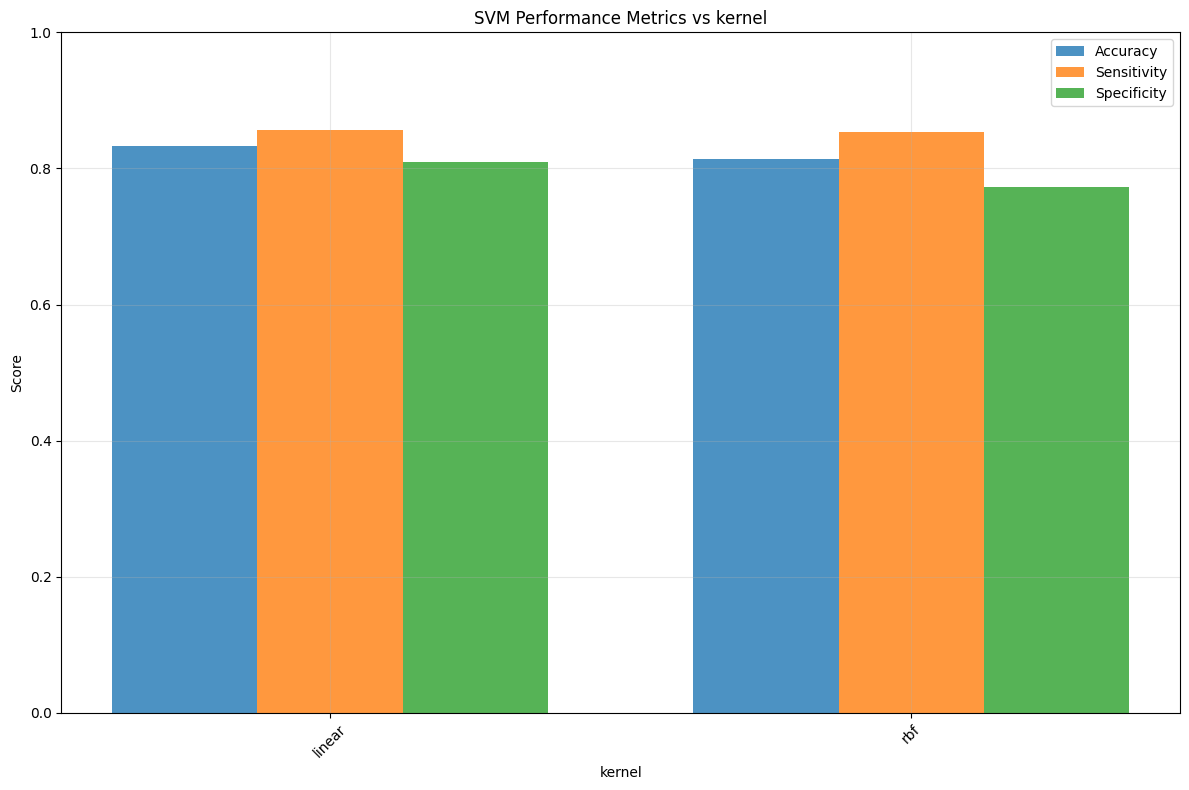

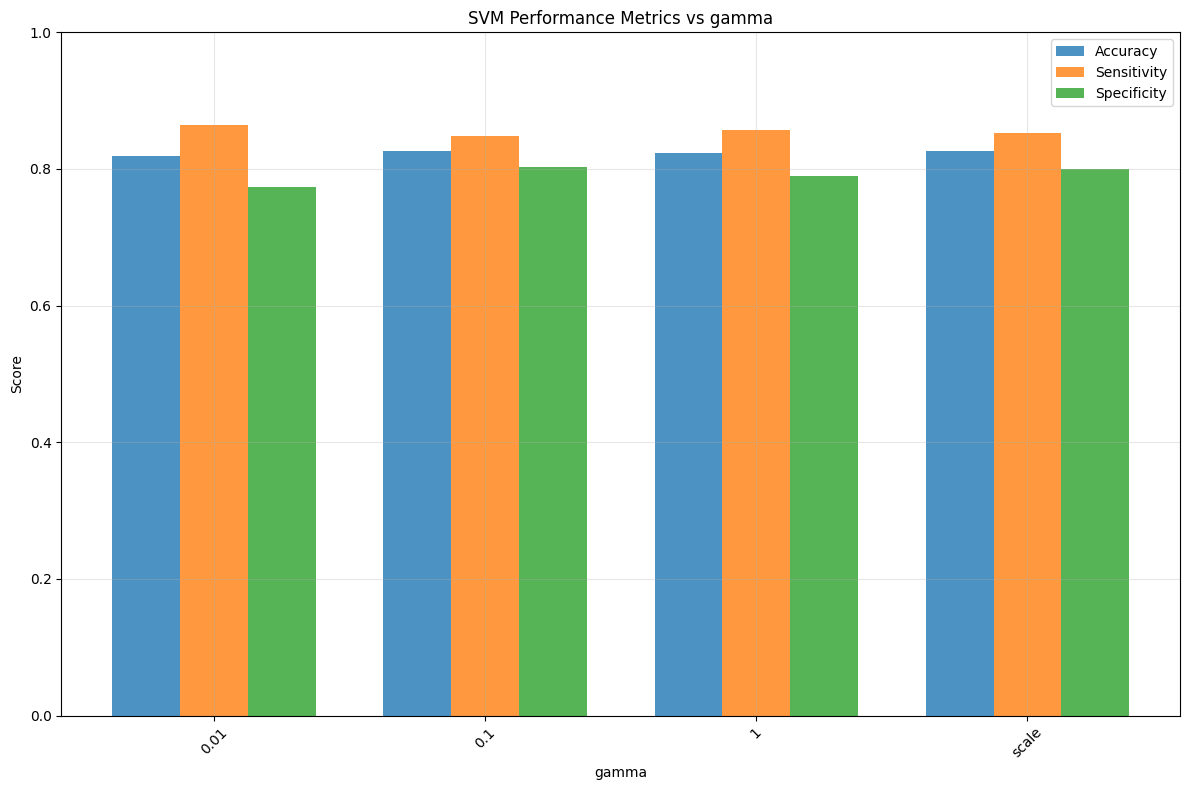

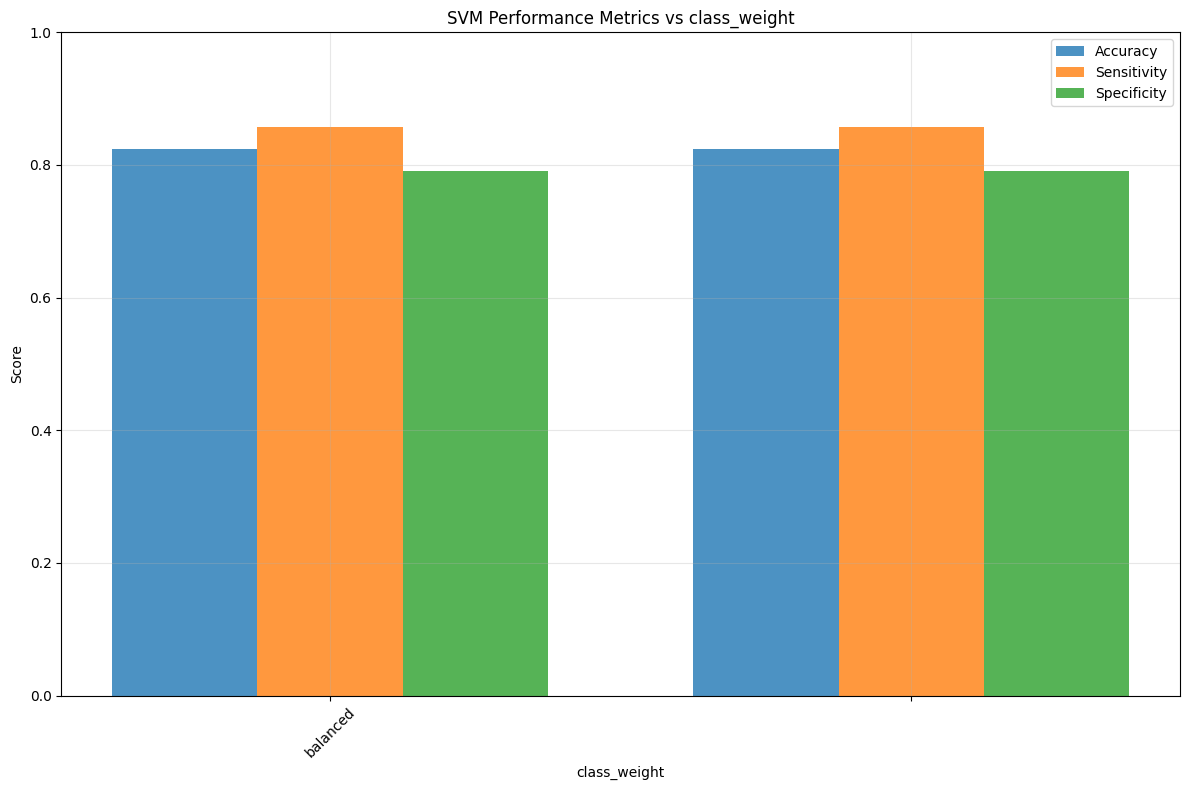


📋 Best SVM parameter combinations for each metric:

🎯 Best Accuracy:
Accuracy: 0.852
C: 10.0
kernel: rbf
gamma: 0.01
class_weight: balanced

🎯 Best Sensitivity:
Sensitivity: 0.927
C: 10.0
kernel: rbf
gamma: scale
class_weight: balanced

🎯 Best Specificity:
Specificity: 0.900
C: 1.0
kernel: rbf
gamma: scale
class_weight: None


In [36]:
# 📊 Detailed Results Analysis (Same as other models)
print("\n📊 Step 5: Detailed Parameter Analysis")
svm_detailed_results = []

print("Calculating detailed metrics for all SVM parameter combinations...")
for i, params in enumerate(svm_grid_search.cv_results_['params']):
    # Create SVM model with these parameters
    svm_model = SVC(**params, random_state=42, probability=True)

    # Apply calibration
    calibrated_svm_model = CalibratedClassifierCV(svm_model, method='isotonic', cv=3)
    calibrated_svm_model.fit(X_train_selected_svm, y_train)

    # Get predictions with same custom threshold
    y_proba_svm = calibrated_svm_model.predict_proba(X_test_selected_svm)[:, 1]
    y_pred_svm = (y_proba_svm >= best_threshold_svm).astype(int)

    # Calculate metrics
    acc_svm = accuracy_score(y_test, y_pred_svm)
    sensitivity_svm = recall_score(y_test, y_pred_svm)

    # Calculate specificity
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    tn, fp = cm_svm[0, 0], cm_svm[0, 1]
    specificity_svm = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Store results
    result = params.copy()
    result.update({
        'accuracy': acc_svm,
        'sensitivity': sensitivity_svm,
        'specificity': specificity_svm
    })
    svm_detailed_results.append(result)

    if (i + 1) % 50 == 0:
        print(f"Processed {i + 1}/{len(svm_grid_search.cv_results_['params'])} combinations...")

# Convert to DataFrame
svm_detailed_df = pd.DataFrame(svm_detailed_results)

# 📈 Plot for each SVM hyperparameter
svm_hyperparameters = ['C', 'kernel', 'gamma', 'class_weight']

for param in svm_hyperparameters:
    plt.figure(figsize=(12, 8))

    # Get unique values for this parameter
    unique_values = svm_detailed_df[param].unique()

    if param in ['kernel', 'class_weight']:
        # Categorical parameter - use bar plot
        metrics_by_param_svm = svm_detailed_df.groupby(param)[['accuracy', 'sensitivity', 'specificity']].mean()

        x_pos = np.arange(len(unique_values))
        width = 0.25

        plt.bar(x_pos - width, metrics_by_param_svm['accuracy'], width, label='Accuracy', alpha=0.8)
        plt.bar(x_pos, metrics_by_param_svm['sensitivity'], width, label='Sensitivity', alpha=0.8)
        plt.bar(x_pos + width, metrics_by_param_svm['specificity'], width, label='Specificity', alpha=0.8)

        plt.xlabel(param)
        plt.ylabel('Score')
        plt.title(f'SVM Performance Metrics vs {param}')
        plt.xticks(x_pos, unique_values, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

    elif param == 'gamma':
        # Handle mixed string/numeric gamma values
        metrics_by_param_svm = svm_detailed_df.groupby(param)[['accuracy', 'sensitivity', 'specificity']].mean()

        # Convert gamma values to strings for consistent plotting
        gamma_labels = [str(g) for g in metrics_by_param_svm.index]
        x_pos = np.arange(len(gamma_labels))
        width = 0.25

        plt.bar(x_pos - width, metrics_by_param_svm['accuracy'], width, label='Accuracy', alpha=0.8)
        plt.bar(x_pos, metrics_by_param_svm['sensitivity'], width, label='Sensitivity', alpha=0.8)
        plt.bar(x_pos + width, metrics_by_param_svm['specificity'], width, label='Specificity', alpha=0.8)

        plt.xlabel(param)
        plt.ylabel('Score')
        plt.title(f'SVM Performance Metrics vs {param}')
        plt.xticks(x_pos, gamma_labels, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

    else:
        # Numeric parameter (C) - use line plot
        metrics_by_param_svm = svm_detailed_df.groupby(param)[['accuracy', 'sensitivity', 'specificity']].mean().sort_index()

        plt.plot(metrics_by_param_svm.index, metrics_by_param_svm['accuracy'], marker='o', label='Accuracy', linewidth=2)
        plt.plot(metrics_by_param_svm.index, metrics_by_param_svm['sensitivity'], marker='s', label='Sensitivity', linewidth=2)
        plt.plot(metrics_by_param_svm.index, metrics_by_param_svm['specificity'], marker='^', label='Specificity', linewidth=2)

        plt.xlabel(param)
        plt.ylabel('Score')
        plt.title(f'SVM Performance Metrics vs {param}')
        plt.xscale('log')  # Log scale for C parameter
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.ylim(0, 1)
    plt.show()

# 📊 Summary table of best combinations for each metric
print("\n📋 Best SVM parameter combinations for each metric:")
print("\n🎯 Best Accuracy:")
best_acc_idx_svm = svm_detailed_df['accuracy'].idxmax()
print(f"Accuracy: {svm_detailed_df.loc[best_acc_idx_svm, 'accuracy']:.3f}")
for param in svm_hyperparameters:
    print(f"{param}: {svm_detailed_df.loc[best_acc_idx_svm, param]}")

print("\n🎯 Best Sensitivity:")
best_sens_idx_svm = svm_detailed_df['sensitivity'].idxmax()
print(f"Sensitivity: {svm_detailed_df.loc[best_sens_idx_svm, 'sensitivity']:.3f}")
for param in svm_hyperparameters:
    print(f"{param}: {svm_detailed_df.loc[best_sens_idx_svm, param]}")

print("\n🎯 Best Specificity:")
best_spec_idx_svm = svm_detailed_df['specificity'].idxmax()
print(f"Specificity: {svm_detailed_df.loc[best_spec_idx_svm, 'specificity']:.3f}")
for param in svm_hyperparameters:
    print(f"{param}: {svm_detailed_df.loc[best_spec_idx_svm, param]}")

In [37]:
# 📈 Training Size Analysis (Same as other models)
print("\n📊 Step 6: Training Size Analysis")
train_sizes_svm = [0.2, 0.4, 0.6, 0.8, 1.0]
svm_accuracies = []
svm_recalls = []
svm_specificities = []

final_svm_model_full_data = None

print("\nRésultats SVM pour chaque taille de données d'entraînement :\n")

for size in train_sizes_svm:
    acc_temp_svm, rec_temp_svm, spec_temp_svm = [], [], []

    for seed in range(10):
        if size < 1.0:
            X_train_part_svm, _, y_train_part_svm, _ = train_test_split(
                X_train_selected_svm, y_train, train_size=size, random_state=seed
            )
        else:
            X_train_part_svm = X_train_selected_svm
            y_train_part_svm = y_train

        # Clone and calibrate the best SVM model
        svm_model = clone(best_svm_model)
        calibrated_svm_model = CalibratedClassifierCV(svm_model, method='isotonic', cv=3)
        calibrated_svm_model.fit(X_train_part_svm, y_train_part_svm)

        # Save model trained with 100% of the data and seed 0
        if size == 1.0 and seed == 0:
            final_svm_model_full_data = calibrated_svm_model

        # Probabilités + seuil personnalisé
        y_proba_svm = calibrated_svm_model.predict_proba(X_test_selected_svm)[:, 1]
        y_pred_svm = (y_proba_svm >= best_threshold_svm).astype(int)

        acc_temp_svm.append(accuracy_score(y_test, y_pred_svm))
        rec_temp_svm.append(recall_score(y_test, y_pred_svm))

        cm_svm = confusion_matrix(y_test, y_pred_svm)
        TN = cm_svm[0, 0]
        FP = cm_svm[0, 1]
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        spec_temp_svm.append(spec)

    acc_mean_svm = np.mean(acc_temp_svm)
    rec_mean_svm = np.mean(rec_temp_svm)
    spec_mean_svm = np.mean(spec_temp_svm)

    svm_accuracies.append(acc_mean_svm)
    svm_recalls.append(rec_mean_svm)
    svm_specificities.append(spec_mean_svm)

    print(f"Taille {int(size * 100)}% : Accuracy = {acc_mean_svm:.3f} | Recall = {rec_mean_svm:.3f} | Spécificité = {spec_mean_svm:.3f}")


📊 Step 6: Training Size Analysis

Résultats SVM pour chaque taille de données d'entraînement :

Taille 20% : Accuracy = 0.780 | Recall = 0.849 | Spécificité = 0.710
Taille 40% : Accuracy = 0.800 | Recall = 0.885 | Spécificité = 0.713
Taille 60% : Accuracy = 0.816 | Recall = 0.876 | Spécificité = 0.755
Taille 80% : Accuracy = 0.817 | Recall = 0.895 | Spécificité = 0.738
Taille 100% : Accuracy = 0.840 | Recall = 0.927 | Spécificité = 0.750


In [38]:
# 📌 SVM Evaluation on Training Set
print("\n🔍 SVM Evaluation on Training Set")

# Use final trained SVM model on 100% data
final_svm_model = final_svm_model_full_data

# Predict probabilities and labels on training set
y_proba_train_svm = final_svm_model.predict_proba(X_train_selected_svm)[:, 1]
y_pred_train_svm = (y_proba_train_svm >= best_threshold_svm).astype(int)

# Metrics on training set
acc_train_svm = accuracy_score(y_train, y_pred_train_svm)
recall_train_svm = recall_score(y_train, y_pred_train_svm)
precision_train_svm = precision_score(y_train, y_pred_train_svm)
f1_train_svm = f1_score(y_train, y_pred_train_svm)
roc_auc_train_svm = roc_auc_score(y_train, y_proba_train_svm)

# Confusion matrix and specificity
tn_train_svm, fp_train_svm, fn_train_svm, tp_train_svm = confusion_matrix(y_train, y_pred_train_svm).ravel()
specificity_train_svm = tn_train_svm / (tn_train_svm + fp_train_svm) if (tn_train_svm + fp_train_svm) > 0 else 0

# Print results
print(f"Accuracy: {acc_train_svm:.3f}")
print(f"Recall (Sensitivity): {recall_train_svm:.3f}")
print(f"Specificity (True Negative Rate): {specificity_train_svm:.3f}")
print(f"Precision: {precision_train_svm:.3f}")
print(f"F1 Score: {f1_train_svm:.3f}")
print(f"ROC AUC: {roc_auc_train_svm:.3f}")


🔍 SVM Evaluation on Training Set
Accuracy: 0.738
Recall (Sensitivity): 0.922
Specificity (True Negative Rate): 0.544
Precision: 0.680
F1 Score: 0.783
ROC AUC: 0.880



📊 Step 7: Final SVM Model Evaluation

✅ **Final SVM Evaluation on Test Set** ✅
Accuracy: 0.840
Recall (Sensitivity): 0.927
Specificity (True Negative Rate): 0.7500
Precision: 0.792
F1 Score: 0.854
ROC AUC: 0.888

📋 SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82        40
           1       0.79      0.93      0.85        41

    accuracy                           0.84        81
   macro avg       0.85      0.84      0.84        81
weighted avg       0.85      0.84      0.84        81



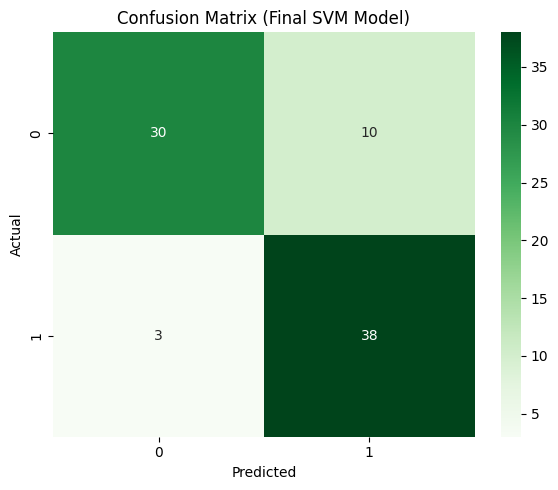

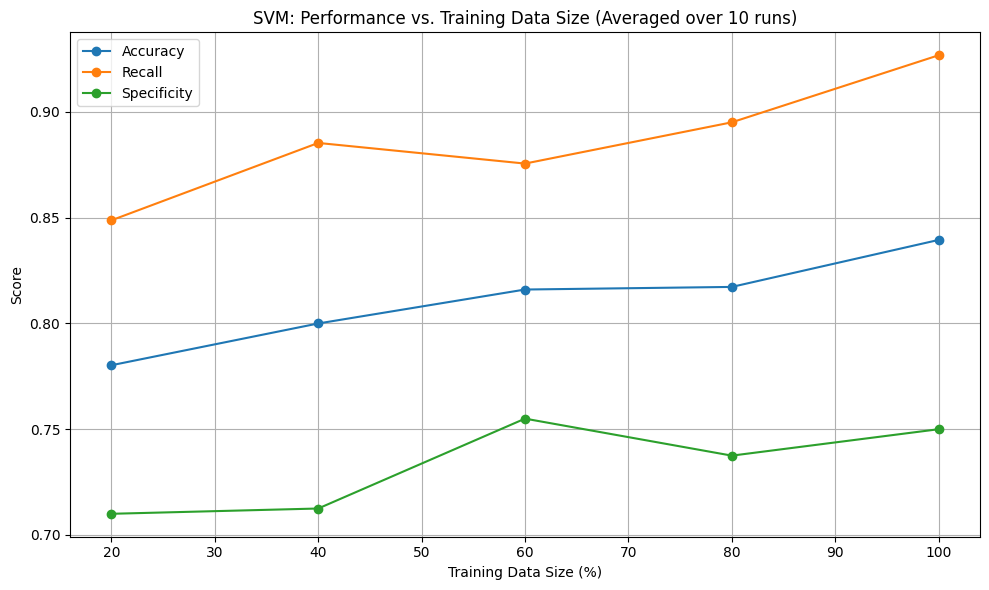


🎉 SVM Analysis Complete!


In [39]:
# 📌 Final SVM Evaluation (Same logic as XGBoost)
print("\n📊 Step 7: Final SVM Model Evaluation")
final_svm_model = final_svm_model_full_data

# Predictions with the optimized threshold
y_proba_final_svm = final_svm_model.predict_proba(X_test_selected_svm)[:, 1]
y_pred_final_svm = (y_proba_final_svm >= best_threshold_svm).astype(int)

# Final Metrics
acc_final_svm = accuracy_score(y_test, y_pred_final_svm)
recall_final_svm = recall_score(y_test, y_pred_final_svm)
precision_final_svm = precision_score(y_test, y_pred_final_svm)
f1_final_svm = f1_score(y_test, y_pred_final_svm)
roc_auc_final_svm = roc_auc_score(y_test, y_proba_final_svm)

# Confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final_svm).ravel()
specificity_final_svm = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n✅ **Final SVM Evaluation on Test Set** ✅")
print(f"Accuracy: {acc_final_svm:.3f}")
print(f"Recall (Sensitivity): {recall_final_svm:.3f}")
print(f"Specificity (True Negative Rate): {specificity_final_svm:.4f}")
print(f"Precision: {precision_final_svm:.3f}")
print(f"F1 Score: {f1_final_svm:.3f}")
print(f"ROC AUC: {roc_auc_final_svm:.3f}")

# Classification Report
print("\n📋 SVM Classification Report:")
print(classification_report(y_test, y_pred_final_svm, target_names=['0', '1']))

# Confusion Matrix
cm_final_svm = confusion_matrix(y_test, y_pred_final_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title("Confusion Matrix (Final SVM Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
svm_cm = confusion_matrix(y_test, y_pred_final_svm)
svm_tn, svm_fp, svm_fn, svm_tp = svm_cm.ravel()
specificity_svm = svm_tn / (svm_tn + svm_fp)

# 📊 Training Size Performance Plot
plt.figure(figsize=(10, 6))
plt.plot([int(s * 100) for s in train_sizes_svm], svm_accuracies, marker='o', label='Accuracy')
plt.plot([int(s * 100) for s in train_sizes_svm], svm_recalls, marker='o', label='Recall')
plt.plot([int(s * 100) for s in train_sizes_svm], svm_specificities, marker='o', label='Specificity')
plt.xlabel("Training Data Size (%)")
plt.ylabel("Score")
plt.title("SVM: Performance vs. Training Data Size (Averaged over 10 runs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n🎉 SVM Analysis Complete!")
print("=" * 60)


🏆 FINAL MODEL COMPARISON SUMMARY
           Model  Accuracy  Sensitivity  Specificity  Precision  F1_Score  \
0  Random Forest     0.840        0.951        0.725      0.780     0.857   
1        XGBoost     0.778        0.951        0.600      0.709     0.812   
2            SVM     0.840        0.927        0.750      0.792     0.854   

   ROC_AUC  
0    0.921  
1    0.939  
2    0.888  


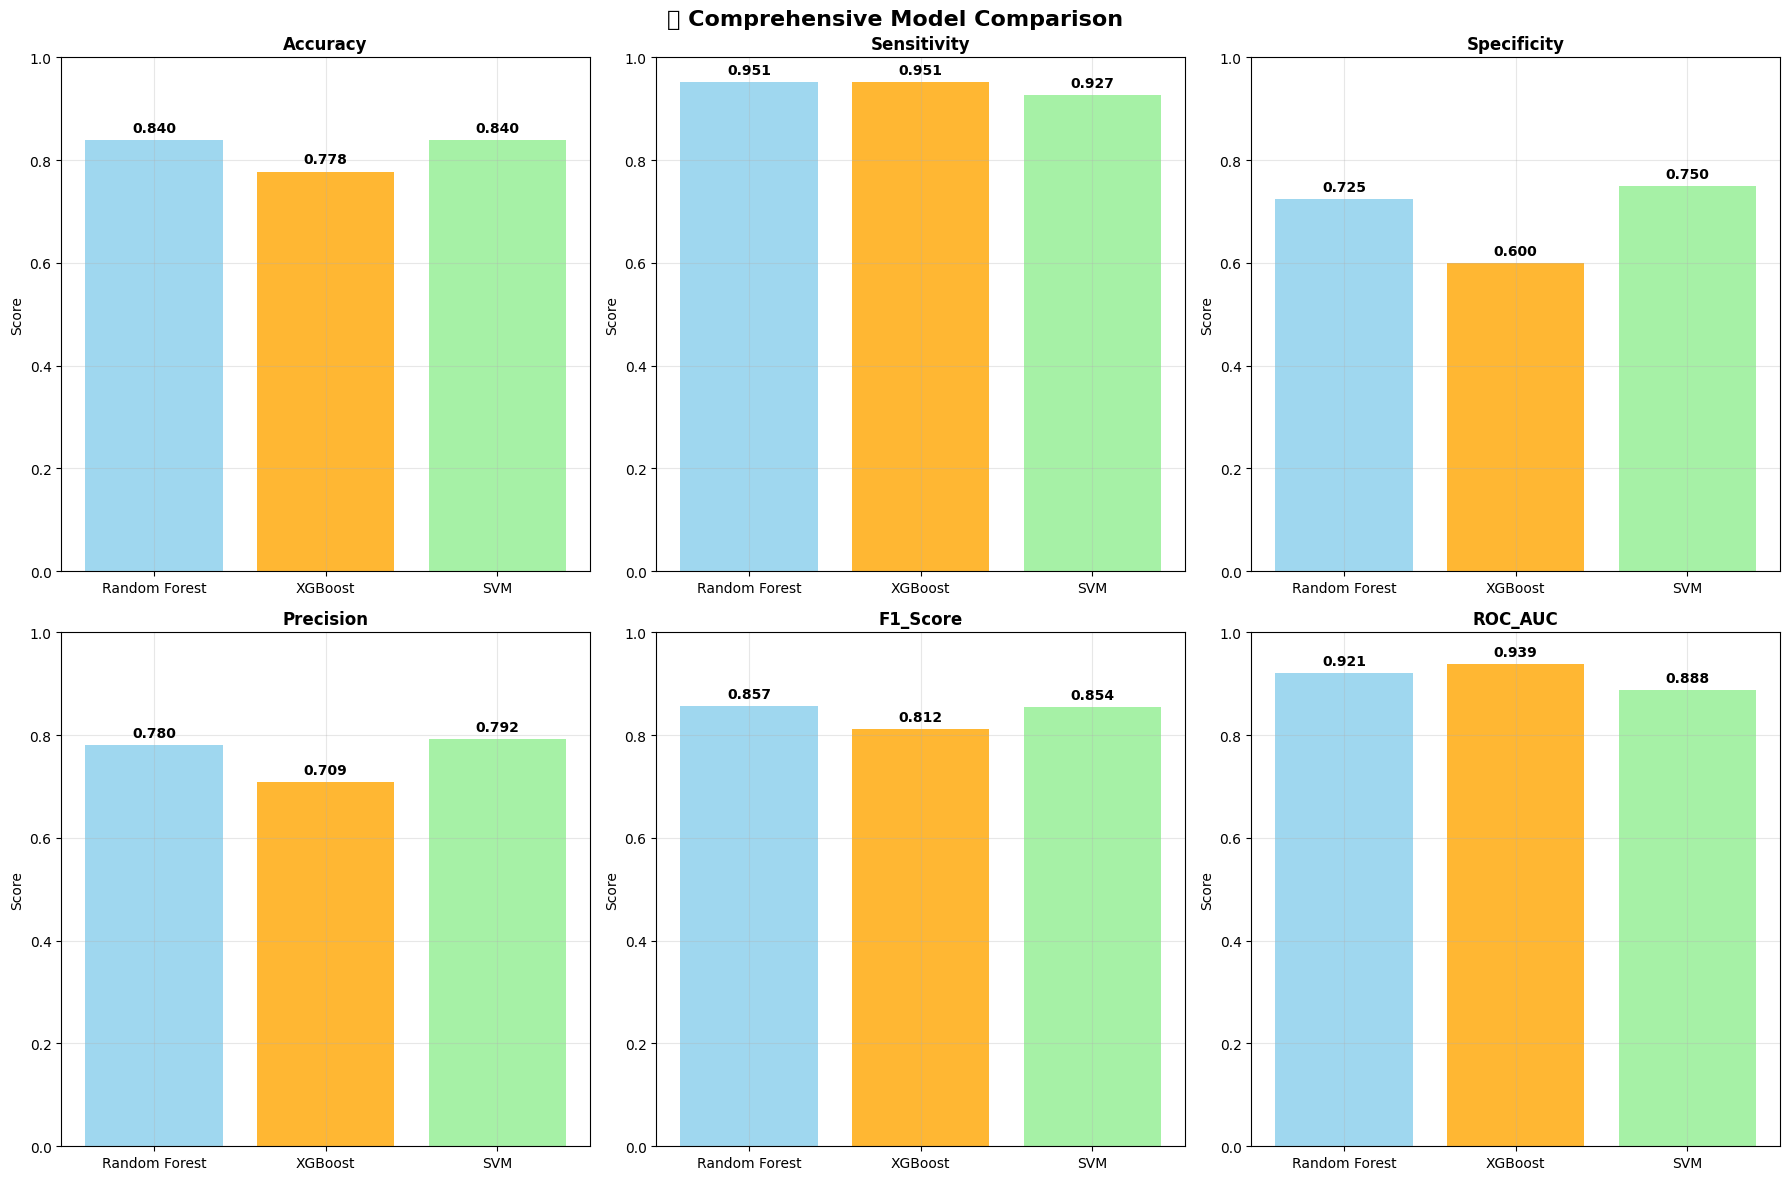


🎯 Best performing model for each metric:
Accuracy: Random Forest (0.840)
Sensitivity: Random Forest (0.951)
Specificity: SVM (0.750)
Precision: SVM (0.792)
F1_Score: Random Forest (0.857)
ROC_AUC: XGBoost (0.939)


In [40]:
# 📊 FINAL COMPARISON BETWEEN ALL THREE MODELS
print("\n" + "="*80)
print("🏆 FINAL MODEL COMPARISON SUMMARY")
print("="*80)

comparison_data = {
    'Model': ['Random Forest', 'XGBoost', 'SVM'],
    'Accuracy': [acc_final, acc_final_xgb, acc_final_svm],
    'Sensitivity': [recall_final, recall_final_xgb, recall_final_svm],
    'Specificity': [specificity_rf, specificity_xgb, specificity_svm],
    'Precision': [precision_final, precision_final_xgb, precision_final_svm],
    'F1_Score': [f1_final, f1_final_xgb, f1_final_svm],
    'ROC_AUC': [roc_auc_final, roc_auc_final_xgb, roc_auc_final_svm]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(3))

# 📊 Comparative Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🏆 Comprehensive Model Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1_Score', 'ROC_AUC']
colors = ['skyblue', 'orange', 'lightgreen']

for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors, alpha=0.8)
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎯 Best performing model for each metric:")
for metric in metrics:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_score = comparison_df.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_score:.3f})")
